Show the Python version used.

In [1]:
!python --version

Python 3.10.12


Install and import required dependencies.

In [2]:
!pip install pandas pyarrow aiohttp aiohttp-retry bs4 tqdm aiofiles aiocsv requests tensorflow matplotlib seaborn scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 3.2 MB/s eta 0:00:00


In [29]:
# for building a dataset
import pandas as pd
import numpy as np

# for scraping data from the Web
import aiohttp
import asyncio
from aiohttp_retry import RetryClient, ListRetry
from bs4 import BeautifulSoup
import json
import aiofiles
from tqdm.notebook import tqdm
from aiocsv import AsyncWriter
import random
import requests

# for preparing data to neural network
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

# for building neural network
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.regularizers import l1, l2, l1_l2

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# display configs
tqdm.pandas()
pd.set_option('display.max_rows', None)

Some stages of this project are implemented in Google Colab, so, we mount a Google Drive as a persistent storage.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1. Defining the problem and assembling a dataset.
This project aims to predict a movie's box office based on the movie's attributes.
We are going to use the following features:
1. Release Year.
2. List of genres.
2. List of directors.
3. List of writers.
4. List of producers.
5. List of actors.

The target variable is a box office expressed in US dollars.

Selecting features is based on my heuristic perception that such a set of features can tell at least something about a possible movie's box office. So, there is no guarantee that such an approach works. That is the hypothesis we are going to check.

Using **crew and actors**' data is understandable because those are the people who almost directly influence the quality of a film and its marketing.
**Year** is used because the same people may have different capabilities, skills, and popularity in different years. For example, even the famous actors were not well-known at some time. And if we do not feed a neural network with a year feature, it can not learn that.
**Genres** are used because the same crew may be pretty successful in one film genre but have a disaster in another.

There are many more factors that may influence a movie's box office. But in this project, I hypothesize that, given even those features, a box office can be predicted with higher precision than just averaging all the box offices. If it succeeds, additional features may be considered to improve the prediction.

We don't consider world events like economic crises, pandemics, etc., as they require a more complex model. And we hypothesize that their influence won't make the prediction worse than the chosen baseline (average box office).

The described task is a scalar regression task.

There is no ready dataset with all the data needed. So, below, I build such a dataset from different sources like ready IMDB datasets, web scraping and manual collection of some features.

We start with using official IMDB datasets: https://developer.imdb.com/non-commercial-datasets/.

The first is **title.basics.tsv** which provides title id, release year and genres.

In [9]:
movies_df = pd \
    .read_csv(
        '/content/drive/MyDrive/data/title.basics.tsv',
        delimiter='\t',
        usecols=['tconst', 'titleType', 'startYear', 'genres'],
        na_values='\\N'
    ) \
    .dropna() \
    .query('titleType == "movie"') \
    .drop('titleType', axis = 'columns') \
    .astype({'tconst': 'str', 'startYear': np.uint16})

movies_df['genres'] = movies_df['genres'].str.split(',')

print(movies_df.shape)
print(movies_df.dtypes)
movies_df.sample(10)

(505076, 3)
tconst       object
startYear    uint16
genres       object
dtype: object


,tconst,startYear,genres
2141199,tt12116082,2022,[Drama]
4180368,tt15893582,2014,[Drama]
135566,tt0139686,1929,"[Comedy, Drama, Romance]"
120483,tt0123710,1985,[Adult]
4750668,tt1818388,2010,[Documentary]
100111,tt0102414,1990,[Drama]
1968632,tt1180311,2009,"[Documentary, Drama]"
8033545,tt4378452,2015,"[Documentary, War]"
6913647,tt28659906,2020,[Drama]
37232,tt0037902,1945,[Western]


The second official IMDB dataset is **title.crew.tsv** which provides data about directors and writers.

In [10]:
movies_crew_df = pd \
    .read_csv(
        '/content/drive/MyDrive/data/title.crew.tsv',
        delimiter='\t',
        usecols=['tconst', 'directors', 'writers'],
        na_values='\\N',
    ) \
    .dropna()

movies_crew_df['directors'] = movies_crew_df['directors'].str.split(',')
movies_crew_df['writers'] = movies_crew_df['writers'].str.split(',')

print(movies_crew_df.shape)
print(movies_crew_df.dtypes)
movies_crew_df.sample(10)

(4655701, 3)
tconst       object
directors    object
writers      object
dtype: object


,tconst,directors,writers
493822,tt0513989,"[nm0483582, nm0822570]",[nm1195554]
7091343,tt29437040,[nm1058822],[nm0696538]
771792,tt0797057,[nm2256092],"[nm2256092, nm2258349, nm2258445]"
5532546,tt21607028,"[nm6275733, nm4721857]","[nm6275733, nm4721857]"
22599,tt0022985,[nm0821244],"[nm0340599, nm0566745, nm0734931, nm0907279]"
6546268,tt27500695,[nm14750247],[nm14750247]
9514188,tt7699326,[nm8989867],[nm0481576]
7963681,tt4221758,[nm1057453],[nm1057453]
2274873,tt1236183,"[nm0061792, nm0393207]","[nm3020072, nm3021461]"
7679774,tt3577994,[nm0258066],[nm0710828]


And the third one is **title.principals.tsv** which provides data about producers and actors.

In [11]:
movies_principals_df = pd \
    .read_csv(
        '/content/drive/MyDrive/data/title.principals.tsv',
        delimiter='\t',
        usecols=['tconst', 'nconst', 'category']
    ) \
    .query('category == "actor" | category == "actress" | category == "producer"') \
    .replace({'category': 'actress'}, 'actor') \
    .groupby(['tconst', 'category'])['nconst'] \
    .agg(list) \
    .reset_index() \
    .pivot(index = 'tconst', columns=['category'], values=['nconst']) \
    .dropna() \
    .droplevel(0, axis=1) \
    .reset_index() \
    .rename_axis(None, axis=1) \
    .rename(columns={ "actor": "actors", 'producer': 'producers'})

print(movies_principals_df.shape)
print(movies_principals_df.dtypes)
movies_principals_df.sample(10)

(1995186, 3)
tconst       object
actors       object
producers    object
dtype: object


,tconst,actors,producers
381059,tt10694602,"[nm0223563, nm0015808, nm1492474, nm0214358]","[nm2276241, nm1040162]"
1371843,tt27925152,"[nm10028802, nm10908071, nm12781811, nm12375362]",[nm2519727]
1207367,tt22457460,"[nm1440097, nm2972077, nm4241029, nm4915682]",[nm11394494]
779541,tt14423128,"[nm12243426, nm11968097, nm12243425, nm12243429]",[nm12076759]
1880830,tt8410934,"[nm9005016, nm1113375, nm5415493, nm9834476]",[nm5201562]
1083232,tt19659322,"[nm1363359, nm0303953, nm1779468, nm1301721]",[nm13582188]
668731,tt1317641,"[nm0129492, nm0170567, nm0171915, nm0186469]",[nm0931784]
1251120,tt23858084,"[nm7803109, nm13098590]","[nm8316961, nm10427984]"
624385,tt12790796,"[nm1426682, nm11041118, nm6797738]","[nm11553607, nm11536924]"
1930340,tt9231726,"[nm0142780, nm0350081, nm0350632, nm0575754, n...",[nm1907674]


Now we merge all the 3 processed datasets above into a single one by title id.

In [12]:
movies_df = movies_df \
    .merge(movies_crew_df, on ='tconst') \
    .merge(movies_principals_df, on ='tconst') \
    .rename(columns={ "startYear": "year"})

del movies_crew_df
del movies_principals_df

The next step is to scrape box office amounts from IMDB as there is no full publicly available dataset with such kind of data.

Define helper function to extract box office data from the IMDB page data.

In [ ]:
def get_box_office(page_data):
    """
    Accepts JSON with IMDB page data and extracts box office from it.

    :param page_data: JSON from an IMDB movie page
    :return: pair of box office amount and currency
    """
    next_value = page_data
    for key in ['props', 'pageProps', 'mainColumnData', 'worldwideGross', 'total']:
        if isinstance(next_value, dict):
            next_value = next_value.get(key)
        else:
            return None, None

    if isinstance(next_value, dict):
        amount = next_value.get('amount')
        currency = next_value.get('currency', 'USD')
        return amount, currency

    return None, None

Define a function that scrapes box offices for movies ids provided and saves them to a CSV-file. Using asyncio and web proxies allows us to do it faster.


In [ ]:
async def scrape_box_office(movie_ids, parallelization):
    """
    Scrapes box office amount and currency for all the movie ids provided
    :param movie_ids: list of movie ids to scrape
    :param parallelization: amount of parallel HTTP requests
    :return: resulting CSV file path
    """
    # init async HTTP client with retries
    http_client = RetryClient(
        client_session = aiohttp.ClientSession(
            connector=aiohttp.TCPConnector(limit = 0, ttl_dns_cache=300),
            cookie_jar = aiohttp.DummyCookieJar() # discard cookies
        ),
        raise_for_status = False, # don't raise exceptions
        retry_options= ListRetry(
            # retry for all HTTP statuses except 200 and 404
            statuses = {x for x in range(100, 600) if x not in [200, 404]},
            # 20 retries by 5 seconds (useful for short network outages)
            timeouts = [5] * 20
        )
    )
    # read proxy servers list to avoid blocking from IMDB and speed up scraping (bought on webshare.io)
    proxies = pd.read_csv('proxy-list.csv').iloc[:, 0].tolist()
    # init results queue for saving results and later writing it on disk
    result_buffer = asyncio.Queue()
    # path to the result file
    result_file_path = '/content/drive/MyDrive/data/box_office.csv'
    # init progress bar
    progress_bar = tqdm(total = len(movie_ids), desc='Movies scraped')

    async def run_async_tasks(*tasks):
        """
        Helper function to run async tasks
        :param tasks: tasks to run
        :return:
        """
        semaphore = asyncio.Semaphore(parallelization)

        async def async_task(task):
            async with semaphore:
                return await task

        return await asyncio.gather(*(async_task(task) for task in tasks))

    def retry_on_exception():
        """
        Annotation function to correctly process possible exceptions
        """
        def func_wrapper(f):
            async def wrapper(*args, **kwargs):
                while True:
                    try:
                        return await f(*args, **kwargs)
                    except Exception as e:
                        # print exception for debugging purposes
                        print(f'Exception {e} when scraping summaries for movie {args[0]}, retrying...')
            return wrapper
        return func_wrapper

    @retry_on_exception()
    async def scrape_box_office(movie_id):
        """
        Scrapes box office of a single title
        :param movie_id: title id
        """
        url = f'https://www.imdb.com/title/{movie_id}'
        async with http_client.get(
                url,
                headers = {'User-Agent': f'Random user agent {movie_id}.0'},
                proxy = random.choice(proxies)
        ) as response:
            if not response.ok and response.status != 404:
                # print unexpected status for debugging purposes
                print(f'url = {url}, wrong response {response.status}')
                progress_bar.update(1)
                return

            # retrieve page content
            page = await response.text()
            soup = BeautifulSoup(page, 'html.parser')

            # extract page data JSON
            page_data = json.loads(
                soup.find('script', id='__NEXT_DATA__').text
            )

            # extract box office
            amount, currency = get_box_office(page_data)
            if amount is not None:
                result_buffer.put_nowait([movie_id, amount, currency])

            progress_bar.update(1)

    # create file for writing results and start the web scraping
    async with aiofiles.open(result_file_path,mode="w",encoding="utf-8",newline="") as result_file:
        result_writer = AsyncWriter(result_file)

        # write headers
        await result_writer.writerow(['tconst', 'amount', 'currency'])

        # reads scraped box offices from result_buffer and writes them on disk
        async def write_result_to_file():
            while True:
                await result_writer.writerow(await result_buffer.get())
                result_buffer.task_done()

        # run async background task for writing results on disk
        write_result_to_file_task = asyncio.create_task(
            write_result_to_file()
        )
        # run and await async scraping tasks
        await run_async_tasks(
            *[scrape_box_office(movie_id) for movie_id in movie_ids]
        )

        await http_client.close()

        # wait until all the results are written on disk
        await result_buffer.join()
        # finish the task for writing results on disk
        write_result_to_file_task.cancel()

        # finalize progress bar
        progress_bar.close()

    return result_file_path

Run scraping box offices. As we are running this code in Jupyter notebook environment which already provides EventLoop, we can use await directly.

In [ ]:
await scrape_box_office(
    movie_ids = movies_df.tconst.tolist(),
    parallelization = 100
)

Check the scraped box office data.

In [13]:
movies_box_office_df = pd.read_csv(
    '/content/drive/MyDrive/data/box_office.csv',
    usecols = ['tconst', 'amount', 'currency']
)

print(movies_box_office_df.shape)
print(movies_box_office_df.dtypes)
movies_box_office_df.sample(10)

(36312, 3)
tconst      object
amount       int64
currency    object
dtype: object


,tconst,amount,currency
5445,tt0228277,8741,USD
33081,tt6887540,9031,USD
23498,tt2167266,5853509,USD
33381,tt7158736,3273025,USD
9486,tt0443446,11817815,USD
12006,tt0922358,2008201,USD
6660,tt0305884,12776,USD
22655,tt20251994,2470684,USD
3255,tt0108525,48198019,USD
29414,tt4579582,88,USD


Merge the scraped box offices with the main movies dataset.

In [14]:
movies_df = movies_df.merge(movies_box_office_df, on ='tconst')

del movies_box_office_df

Let's check how many different currencies there are.

In [ ]:
movies_df.currency.value_counts()

USD    36250
INR       55
GBP        2
FRF        1
HKD        1
NPR        1
AUD        1
PKR        1
Name: currency, dtype: int64

We can see that there are box offices in the currencies different from USD. As there is no many of such records, we may manually convert them to USD to have more data for our neural network.
Let's see what years movies with different currencies have.

In [ ]:
movies_df.query('currency != "USD"')[['year', 'currency']]

,year,currency
0,1919,FRF
40,1940,GBP
76,1947,GBP
1169,1982,HKD
5332,1999,INR
5337,1993,INR
5413,1999,INR
5475,1997,INR
5564,2000,INR
5856,2000,INR


I manually collected currency rates for years and currencies given from the following sources:

* FRF - USD: https://canvasresources-prod.le.unimelb.edu.au/projects/CURRENCY_CALC/
* GBP - USD: https://www.measuringworth.com/datasets/exchangepound/result.php?year_source=1900&year_result=2012
* HKD - USD: https://fx.sauder.ubc.ca/etc/USDpages.pdf
* NPR - USD: https://www.exchange-rates.org/exchange-rate-history/npr-usd-2016-12-30
* AUD - USD: https://www.exchange-rates.org/exchange-rate-history/aud-usd-2016-12-30
* PKR - USD: https://www.exchange-rates.org/exchange-rate-history/pkr-usd-2015-12-31
* INR - USD: https://www.bookmyforex.com/blog/1-usd-inr-1947-till-now/

And built the dictionary below.

In [15]:
exchange_rates = {
    'FRF': {
        1919: 0.0924
    },
    'GBP': {
        1940: 3.83,
        1947: 4.03
    },
    'HKD': {
        1982: 0.1648
    },

    'NPR': {
        2016: 0.009213
    },
    'AUD': {
        2016: 0.7202
    },
    'PKR': {
        2015: 0.009527
    },
    'INR': {
        1983: 0.099,
        1984: 0.088,
        1993: 0.0328,
        1995: 0.0308,
        1997: 0.0275,
        1999: 0.0232,
        2000: 0.0223,
        2004: 0.0221,
        2003: 0.0215,
        2006: 0.0221,
        2007: 0.0242,
        2009: 0.0207,
        2010: 0.0219,
        2011: 0.0214,
        2012: 0.0187,
        2013: 0.0177,
        2014: 0.016,
        2015: 0.0159,
        2016: 0.015,
        2017: 0.0148,
        2018: 0.0143
    }
}

Now we can convert the amounts to USD.

In [16]:
movies_df['box_office'] = movies_df \
    .apply(lambda row: row['amount'] if row['currency'] == 'USD' else row['amount'] * exchange_rates[row['currency']][row['year']], axis = 1) \
    .astype(np.int64)
movies_df = movies_df.drop(['amount', 'currency'], axis = 'columns')

I conducted a huge amount of experiments with different variations of the dataset. I don't show all of them here because then the notebook would be enormously big. But the resulting dataset transformations are presented below:

1. Box office range is huge: from 0 dollars to billions of dollars.

In [ ]:
print(movies_df.box_office.min())
print(movies_df.box_office.max())

0
2923706026


That quite significantly impacts the complexity of the model and its predictive power, and requires more computational resources. Thus, I decided to use only title with box office grater than 1 million of dollars and scale their values by 1 million. At the result we have range from 1 to about 3000 which looks more reasonable.

In [17]:
movies_df = movies_df[movies_df['box_office'] >= 1000000]
movies_df['box_office'] = movies_df['box_office'] \
    .apply(lambda box_office: box_office / 1000000) \
    .astype(np.float32)

2. I assumed that the titles filmed earlier than 1950 can not provide significant information for prediction purposes as most of the crew participating in their creation are already dead. So, I filtered out those titles. That allows for a decreased amount of features and impaction of outliers.

In [18]:
movies_df = movies_df[movies_df['year'] >= 1950]

3. Some persons were mentioned only once or twice in the specific role (director or writer or actor, etc.) across all the movies. I also filtered out such persons. As a result, I significantly decreased the amount of insignificant features.

In [19]:
def remove_rare_instances(series):
    histogram = series.explode().value_counts()
    return series.apply(lambda persons: [person for person in persons if histogram[person] > 2])

movies_df['directors'] = remove_rare_instances(movies_df['directors'])
movies_df['writers'] = remove_rare_instances(movies_df['writers'])
movies_df['actors'] = remove_rare_instances(movies_df['actors'])
movies_df['producers'] = remove_rare_instances(movies_df['producers'])

movies_df = movies_df[movies_df.apply(lambda x: any(len(x[col]) > 0 for col in ['directors', 'writers', 'actors', 'producers']), axis=1)]

Let's check the resulting dataset.

In [ ]:
print(movies_df.shape)
print(movies_df.dtypes)
movies_df.sample(10)

(15314, 8)
tconst         object
year           uint16
genres         object
directors      object
writers        object
actors         object
producers      object
box_office    float32
dtype: object


,tconst,year,genres,directors,writers,actors,producers,box_office
32995,tt6857280,2017,"[Comedy, Drama]",[],[],"[nm5341380, nm1981215]",[nm1295594],5.428592
16609,tt1304568,2008,[Comedy],[],[nm2500643],"[nm1863784, nm1726978]",[nm1147588],2.149153
15004,tt1170402,2008,[Comedy],[],[],[],"[nm0759840, nm0471124, nm0483440]",4.641951
2843,tt0103759,1992,"[Crime, Drama, Thriller]",[nm0001206],[],[nm0000172],"[nm0437391, nm0696299]",2.038916
24706,tt2374144,2013,"[Action, Animation, Comedy]",[],"[nm2985912, nm1737449]","[nm0837523, nm1160233, nm1069584]",[nm10057981],15.954700
35783,tt9272572,2019,"[Crime, Drama, Thriller]",[nm1082611],[],[nm0376826],"[nm0108426, nm0938347]",5.567617
11115,tt0803100,2009,"[Adventure, Family]",[nm0228542],"[nm0228542, nm0728894]","[nm2180198, nm1675498]","[nm2264541, nm0065376]",4.628777
7205,tt0333766,2004,"[Comedy, Drama, Romance]",[nm0103785],[nm0103785],"[nm0103785, nm0765597, nm0000204, nm0000453]","[nm0008330, nm1344784, nm0357074]",36.071789
27987,tt3699104,2017,"[Action, Crime, Thriller]",[],[],"[nm0481709, nm1833620, nm5328306]",[nm0399003],2.321975
11831,tt0888496,2006,"[Comedy, Sci-Fi]",[],[],[nm1133014],[nm0698271],1.059366


Now, we have to split it into the training and testing parts.
As data are sequential because of the year feature, making a random split does not make sense. I decided to limit the upper bound of the whole dataset to 2023, as 2024 is still in progress, and its data are incomplete. Titles before 2023 will be used as a training dataset. Titles for 2023 will be used as a test dataset. Such a split provides enough data for both parts and makes sense from the practical perspective: for each new year, we may update or retrain a neural network for the past years.

In [20]:
train_df = movies_df[movies_df['year'] < 2023]
print(f'train df shape: {train_df.shape}')

test_df = movies_df[movies_df['year'] == 2023]
print(f'test df shape: {test_df.shape}')

train df shape: (14894, 8)
test df shape: (399, 8)


### 2. Choosing a measure of success.
I'm going to rely on MAE (Mean Absolute Error) and on MAPE (Mean Absolute Percentage Error) metrics as they can be interpreted by a human easier than other metrics available in Keras by default.

Based on the metrics chosen I am planning to experiment with several loss functions:
1. MAE (Mean Absolute Error): According to one of the MAE metrics.
2. MAPE (Mean Absolute Percentage Error): According to one of the MAPE metrics.
3. MSLE (Mean Squared Logarithmic Error): Both MAE and MAPE are important. But if optimize only one of them, we may have unexpectedly big values in the another. Sometimes MSLE may provide a balance between MAE and MAPE.

For better understanding of the prediction results, I am also going to build Residuals plot and Residuals distribution plot.

### 3. Deciding on an evaluation protocol.
I decided to go with Maintaining a hold-out validation set for 2 reasons:
1. The dataset samples are sequential because of the year feature. Variations of K-fold validations will mix up samples from different years, which may result in incorrect training and evaluation.
2. As we've seen above, there is enough data in the training dataset for a hold-out validation: 14894 samples.

### 4. Preparing your data.
To feed the data to a neural network, we need to transform the dataset to a tensor with small values. In our case, I decided to use the range [0, 1]. The transformation steps are the following:

1. Normalize years.

In [21]:
min_year = train_df['year'].min()
max_year = 2023

train_normalized_years = ((train_df['year'] - min_year) / (max_year - min_year)).astype(np.float16)
test_normalized_years = np.ones(test_df['year'].shape[0]).astype(np.float16)

2. Transform categorical features to one-hot encoding.
All the other features are categorical. As we have different numbers of persons for each movie, and to avoid the influence of number ordering when using Label Encoding, it has been decided to use One-Hot Encoding. Each person will be a single feature with possible values of 0 or 1.
The code below is partly based on examples from section 3.5.2 of "Deep Learning with Python", 1st edition, by François Chollet.

Define a helper function for one-hot encoding of a single column.

In [22]:
def convert_to_one_hot_encoding(column, tokenizer = None, num_classes = None):
    """
    Perform One-Hot Encoding for the column provided.
    :param column: pd.Series to perform one-hot encoding.
    :param tokenizer: tokenizer for transforming string values to numbers. If not provided, a new tokenizer is created based on values from the column argument.
    :param num_classes: number of different string values in column + 1. If not provided, it is calculated based on tokenized column values.
    :return: the column in one-hot encoding
    """
    if tokenizer is None:
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(column)

    tokenized_column = pd.Series(tokenizer.texts_to_sequences(column))

    if num_classes is None:
        num_classes = tokenized_column.explode().max() + 1

    return (
        tokenizer,
        num_classes,
        tokenized_column.apply(lambda row: np.array(to_categorical(row, num_classes = num_classes).sum(axis=0).astype(np.float16))).values
    )

Perform one-hot encoding of each column.

In [23]:
genres_tokenizer, genres_num_classes, genres_one_hot = convert_to_one_hot_encoding(train_df['genres'])
directors_tokenizer, directors_num_classes, directors_one_hot = convert_to_one_hot_encoding(train_df['directors'])
writers_tokenizer, writers_num_classes, writers_one_hot = convert_to_one_hot_encoding(train_df['writers'])
actors_tokenizer, actors_num_classes, actors_one_hot = convert_to_one_hot_encoding(train_df['actors'])
producers_tokenizer, producers_num_classes, producers_one_hot = convert_to_one_hot_encoding(train_df['producers'])

train_prepared_df = pd.DataFrame({
    'year': train_df['year'],
    'year_normalized': train_normalized_years,
    'genres_one_hot': genres_one_hot,
    'directors_one_hot': directors_one_hot,
    'writers_one_hot': writers_one_hot,
    'actors_one_hot': actors_one_hot,
    'producers_one_hot': producers_one_hot,
    'box_office': train_df['box_office']
})

Now, we need to split the training dataset into training and validation parts. As the samples are sequential, we use movies before 2022 as the training part and movies for 2022 as a validation part. Also, we sort the training part by year to feed and train a neural network more naturally according to the actual sequence of samples.

Extract the training part and build tensors for features and target variables.

In [24]:
partial_train_prepared_df = train_prepared_df[train_prepared_df['year'] < 2022].sort_values('year').reset_index()
partial_train_data = np.concatenate(
    (
        np.stack(partial_train_prepared_df['year_normalized'].apply(lambda year: [year])),
        np.stack(partial_train_prepared_df['genres_one_hot']),
        np.stack(partial_train_prepared_df['directors_one_hot']),
        np.stack(partial_train_prepared_df['writers_one_hot']),
        np.stack(partial_train_prepared_df['actors_one_hot']),
        np.stack(partial_train_prepared_df['producers_one_hot']),
    ),
    axis=1
).astype(np.float16)
partial_train_targets = partial_train_prepared_df['box_office'].to_numpy()

Extract the validation part and build tensors for features and target variables.

In [25]:
validation_train_prepared_df = train_prepared_df[train_prepared_df['year'] == 2022]
validation_train_data = np.concatenate(
    (
        np.stack(validation_train_prepared_df['year_normalized'].apply(lambda year:[year])),
        np.stack(validation_train_prepared_df['genres_one_hot']),
        np.stack(validation_train_prepared_df['directors_one_hot']),
        np.stack(validation_train_prepared_df['writers_one_hot']),
        np.stack(validation_train_prepared_df['actors_one_hot']),
        np.stack(validation_train_prepared_df['producers_one_hot']),
    ),
    axis=1
).astype(np.float16)
validation_train_targets = validation_train_prepared_df['box_office'].to_numpy()

Build tensors for features and target variables of the test part.

In [26]:
test_normalized_years.shape += (1,)

test_data = np.concatenate(
    (
        test_normalized_years,
        np.stack(convert_to_one_hot_encoding(test_df['genres'], genres_tokenizer, genres_num_classes)[2]),
        np.stack(convert_to_one_hot_encoding(test_df['directors'], directors_tokenizer, directors_num_classes)[2]),
        np.stack(convert_to_one_hot_encoding(test_df['writers'], writers_tokenizer, writers_num_classes)[2]),
        np.stack(convert_to_one_hot_encoding(test_df['actors'], actors_tokenizer, actors_num_classes)[2]),
        np.stack(convert_to_one_hot_encoding(test_df['producers'], producers_tokenizer, producers_num_classes)[2]),
    ),
    axis=1
).astype(np.float16)
test_targets = test_df['box_office'].to_numpy()

Let's check how many samples we have in each part of the dataset.

In [ ]:
print(f'Partial train shape: {partial_train_data.shape}')
print(f'Validation train shape: {validation_train_data.shape}')
print(f'Test shape: {test_data.shape}')

Partial train shape: (14442, 13563)
Validation train shape: (452, 13563)
Test shape: (399, 13563)


Save prepared datasets for easier re-usage between runs of Jupyter Notebook.

In [27]:
with open('/content/drive/MyDrive/data/partial_train_data.npy', 'wb') as f:
    np.save(f, partial_train_data)
with open('/content/drive/MyDrive/data/partial_train_targets.npy', 'wb') as f:
    np.save(f, partial_train_targets)

with open('/content/drive/MyDrive/data/validation_train_data.npy', 'wb') as f:
    np.save(f, validation_train_data)
with open('/content/drive/MyDrive/data/validation_train_targets.npy', 'wb') as f:
    np.save(f, validation_train_targets)

with open('/content/drive/MyDrive/data/test_data.npy', 'wb') as f:
    np.save(f, test_data)
with open('/content/drive/MyDrive/data/test_targets.npy', 'wb') as f:
    np.save(f, test_targets)

Clean memory.

In [28]:
del movies_df
del train_df
del train_prepared_df

### 5. Developing a model that does better than a baseline.

Read previously saved training dataset.

In [5]:
with open('/content/drive/MyDrive/data/partial_train_data.npy', 'rb') as f:
    partial_train_data = np.load(f)
with open('/content/drive/MyDrive/data/partial_train_targets.npy', 'rb') as f:
    partial_train_targets = np.load(f)

with open('/content/drive/MyDrive/data/validation_train_data.npy', 'rb') as f:
    validation_train_data = np.load(f)
with open('/content/drive/MyDrive/data/validation_train_targets.npy', 'rb') as f:
    validation_train_targets = np.load(f)

Define the baseline.

In [ ]:
baseline_pred = partial_train_targets.mean()
baseline_mae = np.abs(validation_train_targets - baseline_pred).mean()
baseline_mape = 100 * np.abs((validation_train_targets - baseline_pred) / validation_train_targets).mean()
print(f'Baseline MAE: {baseline_mae}')
print(f'Baseline MAPE: {baseline_mape}')

Baseline MAE: 55.262760162353516
Baseline MAPE: 1206.4183235168457


Now, let's build a very basic neural network.

We use relu as an activation function for hidden layers and don't specify an activation function for the last layer as this is a scalar regression task.

MAE is used as a loss function.

RMSprop with default learning rate is used as an optimizer.

The code below is partly based on examples from section 3.6.3 of "Deep Learning with Python", 1st edition, by François Chollet.

In [ ]:
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(partial_train_data.shape[1],)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop', loss='mae', metrics=['mae', 'mape'])
history = model.fit(
    partial_train_data, partial_train_targets,
    validation_data=(validation_train_data, validation_train_targets),
    epochs = 5, batch_size = 20
)

Epoch 1/5
723/723 [==============================] - 5s 3ms/step - loss: 34.8113 - mae: 34.8113 - mape: 151.1134 - val_loss: 31.3542 - val_mae: 31.3542 - val_mape: 186.8865
Epoch 2/5
723/723 [==============================] - 2s 3ms/step - loss: 28.0114 - mae: 28.0114 - mape: 117.1368 - val_loss: 28.0210 - val_mae: 28.0210 - val_mape: 139.5227
Epoch 3/5
723/723 [==============================] - 2s 3ms/step - loss: 23.4051 - mae: 23.4051 - mape: 91.7405 - val_loss: 26.3003 - val_mae: 26.3003 - val_mape: 100.2786
Epoch 4/5
723/723 [==============================] - 2s 3ms/step - loss: 20.0085 - mae: 20.0085 - mape: 74.7592 - val_loss: 25.3951 - val_mae: 25.3951 - val_mape: 126.3708
Epoch 5/5
723/723 [==============================] - 2s 3ms/step - loss: 17.4490 - mae: 17.4490 - mape: 63.5088 - val_loss: 24.6168 - val_mae: 24.6168 - val_mape: 138.5483


Compare the resulting neural network metrics with the baseline metrics.

In [ ]:
print(f'Baseline MAE: {baseline_mae}, Neural network MAE: {history.history["val_mae"][-1]}')
print(f'Baseline MAPE: {baseline_mape}, Neural network MAPE: {history.history["val_mape"][-1]}')

Baseline MAE: 55.262760162353516, Neural network MAE: 24.616792678833008
Baseline MAPE: 1206.4183235168457, Neural network MAPE: 138.54832458496094


According to the metrics, we can conclude that the neural network built, though it does not show the best results, already has some statistical power.

### 6. Scaling up: developing a model that overfits.

Let's make a larger model and plot its curves during epochs.

Define a helper function for building and training a neural network.

In [6]:
def build_and_train_overfitting_model(loss):
    """
    Build and trains an overfitting neural network.
    :param loss: loss function to use
    :return: history of loss and metrics values during training
    """
    model = models.Sequential()
    model.add(layers.Dense(1024, activation = 'relu', input_shape = (partial_train_data.shape[1],)))
    model.add(layers.Dense(512, activation = 'relu'))
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss = loss, metrics = ['mae', 'mape'])
    history = model \
    .fit(
        partial_train_data, partial_train_targets,
        validation_data=(validation_train_data, validation_train_targets),
        epochs = 50, batch_size = 20
    ) \
    .history

    return history

Build and train a neural network based on MAE loss.

In [ ]:
mae_overfitting_model_history = build_and_train_overfitting_model('mae')

Epoch 1/50
723/723 [==============================] - 4s 4ms/step - loss: 31.0117 - mae: 31.0117 - mape: 146.6071 - val_loss: 25.8508 - val_mae: 25.8508 - val_mape: 147.0234
Epoch 2/50
723/723 [==============================] - 2s 3ms/step - loss: 22.5383 - mae: 22.5383 - mape: 88.6498 - val_loss: 26.5306 - val_mae: 26.5306 - val_mape: 256.4432
Epoch 3/50
723/723 [==============================] - 2s 3ms/step - loss: 18.3149 - mae: 18.3149 - mape: 66.4511 - val_loss: 23.8711 - val_mae: 23.8711 - val_mape: 102.6975
Epoch 4/50
723/723 [==============================] - 2s 3ms/step - loss: 15.6703 - mae: 15.6703 - mape: 53.4421 - val_loss: 22.2777 - val_mae: 22.2777 - val_mape: 119.7833
Epoch 5/50
723/723 [==============================] - 2s 3ms/step - loss: 13.6821 - mae: 13.6821 - mape: 45.5021 - val_loss: 22.4713 - val_mae: 22.4713 - val_mape: 111.2423
Epoch 6/50
723/723 [==============================] - 2s 3ms/step - loss: 12.5164 - mae: 12.5164 - mape: 40.0441 - val_loss: 22.0275 -

Build and train a neural network based on MAPE loss.

In [ ]:
mape_overfitting_model_history = build_and_train_overfitting_model('mape')

Epoch 1/50
723/723 [==============================] - 4s 4ms/step - loss: 66.7730 - mae: 38.2382 - mape: 66.7730 - val_loss: 58.3749 - val_mae: 33.8539 - val_mape: 58.3749
Epoch 2/50
723/723 [==============================] - 2s 3ms/step - loss: 62.0958 - mae: 36.8502 - mape: 62.0958 - val_loss: 56.8164 - val_mae: 33.7493 - val_mape: 56.8164
Epoch 3/50
723/723 [==============================] - 2s 3ms/step - loss: 59.0071 - mae: 35.4397 - mape: 59.0071 - val_loss: 55.7192 - val_mae: 33.6123 - val_mape: 55.7192
Epoch 4/50
723/723 [==============================] - 2s 3ms/step - loss: 55.7909 - mae: 33.7865 - mape: 55.7909 - val_loss: 57.9384 - val_mae: 33.1889 - val_mape: 57.9384
Epoch 5/50
723/723 [==============================] - 2s 3ms/step - loss: 52.3182 - mae: 32.2114 - mape: 52.3182 - val_loss: 58.3830 - val_mae: 32.8606 - val_mape: 58.3830
Epoch 6/50
723/723 [==============================] - 2s 3ms/step - loss: 48.6489 - mae: 30.3672 - mape: 48.6489 - val_loss: 59.3004 - val_m

Build and train a neural network based on MSLE loss.

In [ ]:
msle_overfitting_model_history = build_and_train_overfitting_model('msle')

Epoch 1/50
723/723 [==============================] - 5s 4ms/step - loss: 1.1758 - mae: 31.8698 - mape: 151.5929 - val_loss: 0.9220 - val_mae: 28.4383 - val_mape: 103.7284
Epoch 2/50
723/723 [==============================] - 2s 3ms/step - loss: 0.5227 - mae: 22.3846 - mape: 84.6665 - val_loss: 0.8784 - val_mae: 25.8859 - val_mape: 130.8683
Epoch 3/50
723/723 [==============================] - 2s 3ms/step - loss: 0.3123 - mae: 16.8379 - mape: 58.4928 - val_loss: 0.8812 - val_mae: 24.1390 - val_mape: 153.5550
Epoch 4/50
723/723 [==============================] - 2s 3ms/step - loss: 0.2124 - mae: 13.4425 - mape: 45.0466 - val_loss: 0.9223 - val_mae: 22.8831 - val_mape: 89.7251
Epoch 5/50
723/723 [==============================] - 2s 3ms/step - loss: 0.1602 - mae: 11.2319 - mape: 37.9774 - val_loss: 0.8804 - val_mae: 22.3744 - val_mape: 132.2836
Epoch 6/50
723/723 [==============================] - 3s 3ms/step - loss: 0.1306 - mae: 9.9292 - mape: 33.8093 - val_loss: 0.8338 - val_mae: 21.8

Define a helper function for plotting loss and metrics values depending on an epoch.

The code below is partly based on examples from section 3.6.4 of "Deep Learning with Python", 1st edition, by François Chollet.

In [9]:
def plot_training_history(history, loss_name):
    """
    Plots loss, MAE and MAPE depending on an epoch.
    :param history: history of loss and metrics values during training
    :param loss_name: name of a loss function (used for labeling on the plot)
    :return:
    """
    epochs = range(1, len(history['mae']) + 1)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

    ax1.plot(epochs, history['loss'], 'r', label = 'Training')
    ax1.plot(epochs, history['val_loss'], 'b', label = 'Validation')
    ax1.set_title(f'Training and validation loss ({loss_name})')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel(f'Loss ({loss_name})')
    ax1.legend()

    ax2.plot(epochs, history['mae'], 'r', label = 'Training')
    ax2.plot(epochs, history['val_mae'], 'b', label = 'Validation')
    ax2.set_title(f'Training and validation MAE')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel(f'MAE')
    ax2.legend()

    ax3.plot(epochs, history['mape'], 'r', label = 'Training')
    ax3.plot(epochs, history['val_mape'], 'b', label = 'Validation')
    ax3.set_title(f'Training and validation MAPE')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel(f'MAPE')
    ax3.legend()

    plt.tight_layout()
    plt.show()

Now, we plot graphs for all three variations of the overfitting model.

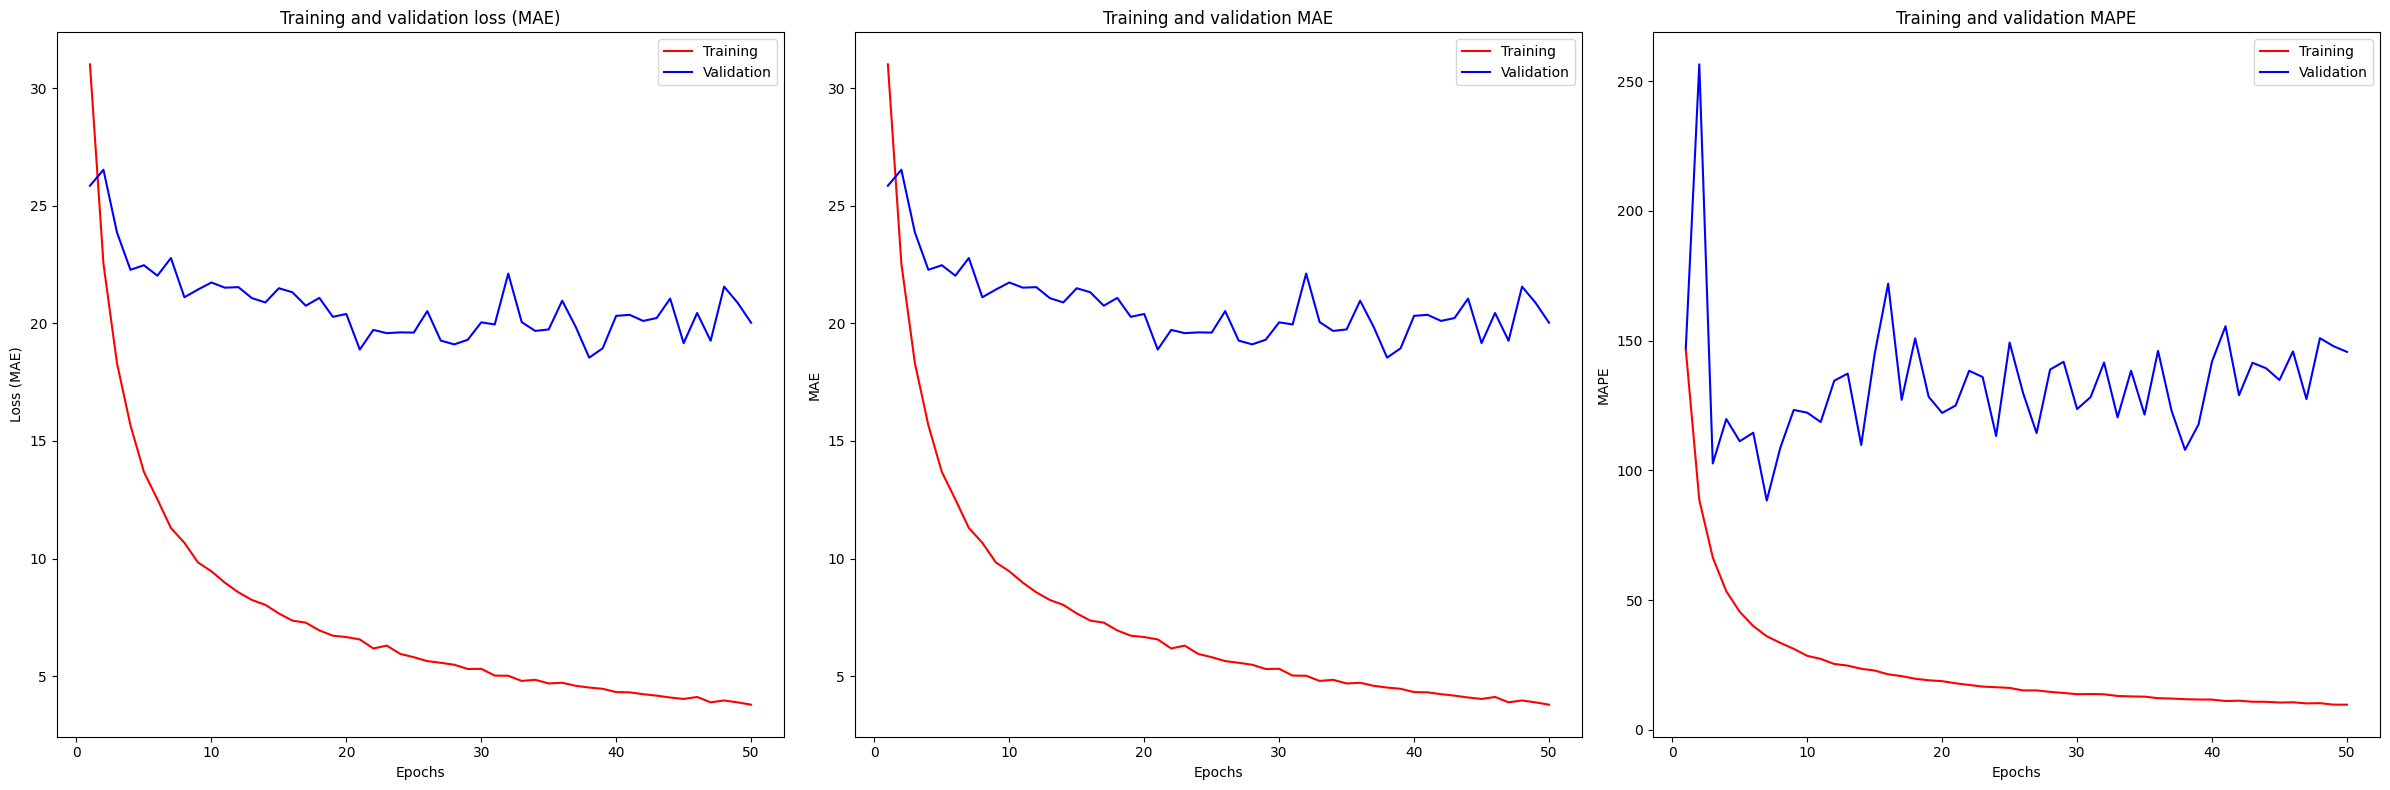

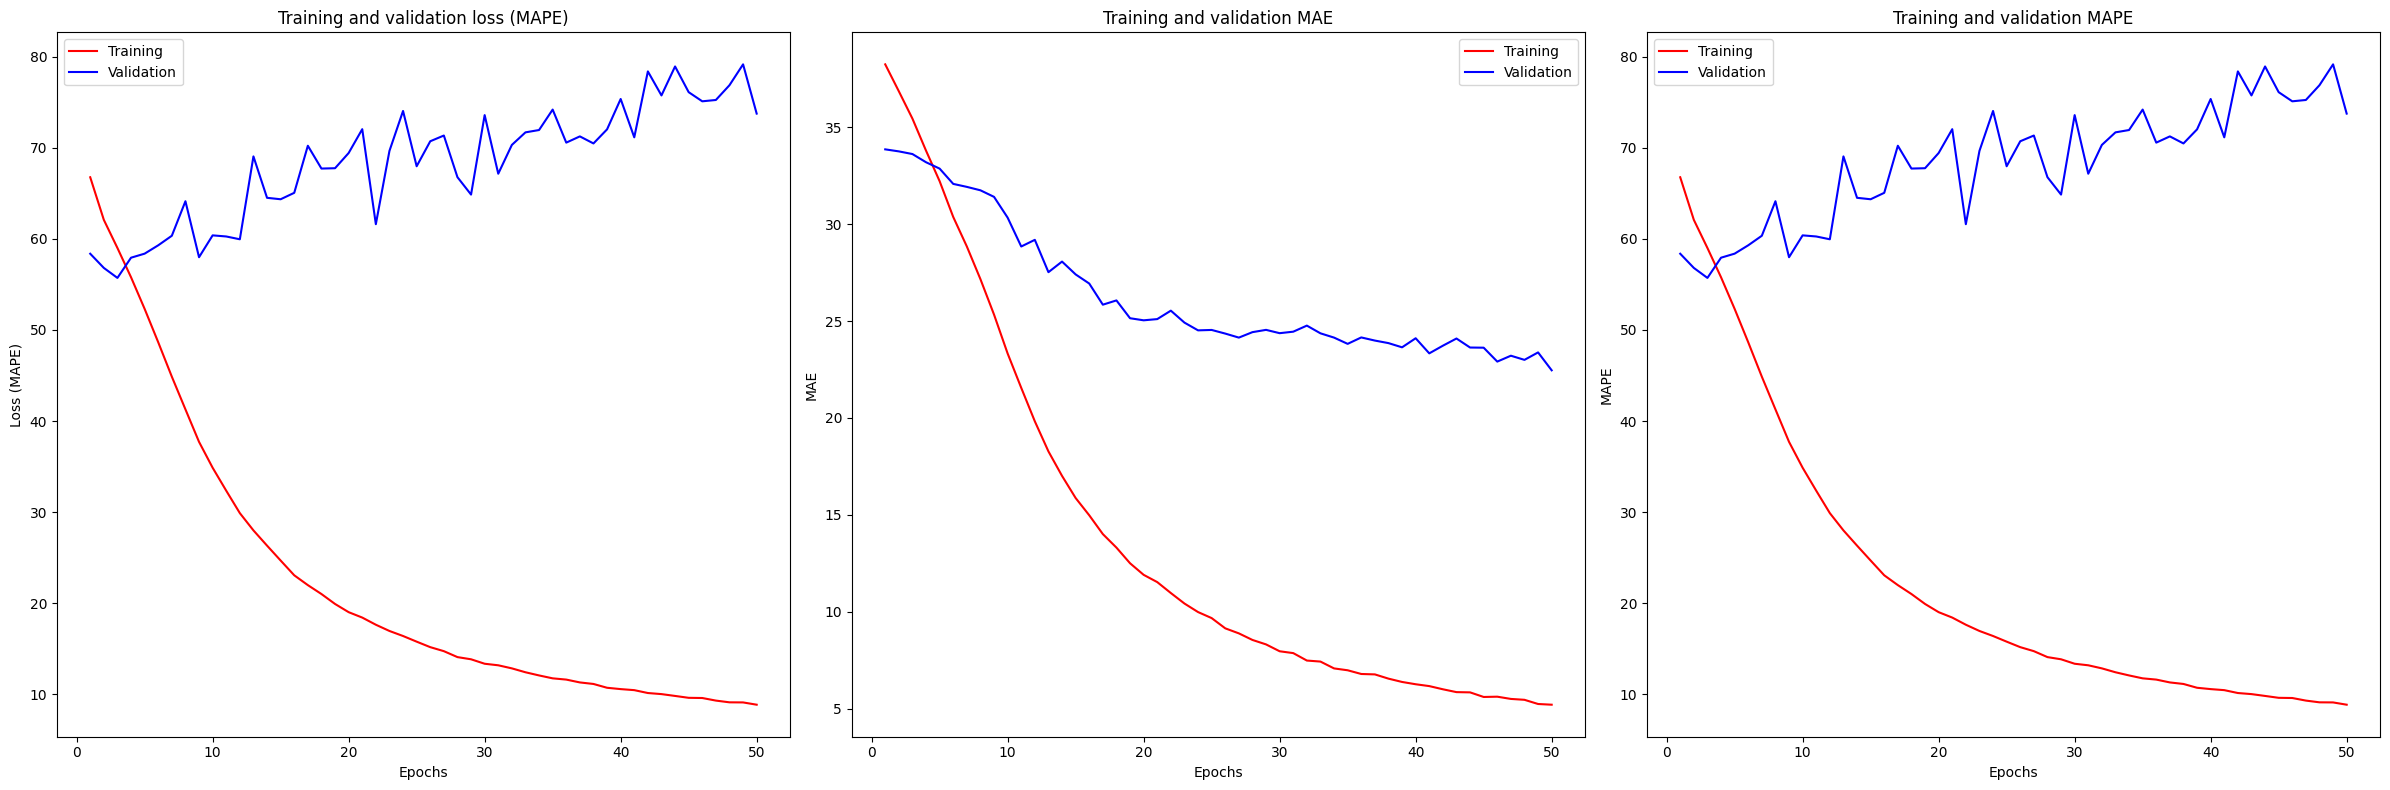

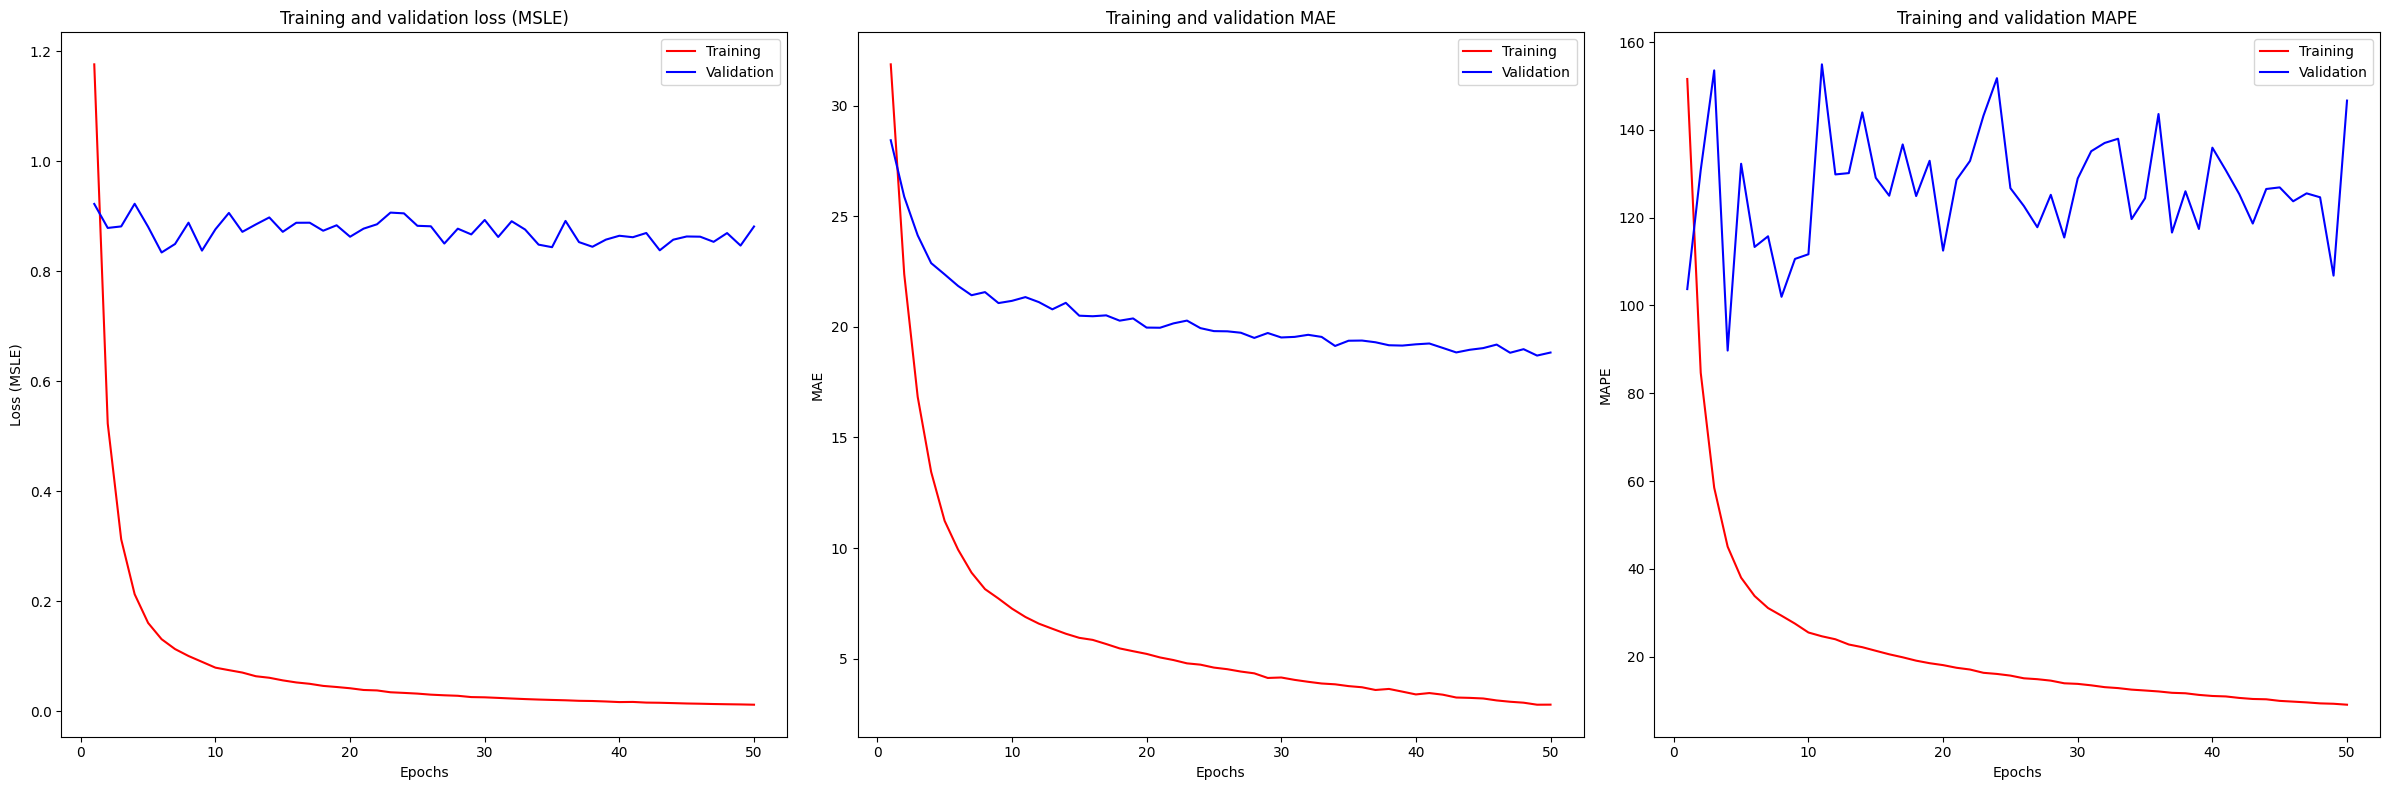

In [ ]:
plot_training_history(mae_overfitting_model_history, 'MAE')
plot_training_history(mape_overfitting_model_history, 'MAPE')
plot_training_history(msle_overfitting_model_history, 'MSLE')

According to the plots, we now have several variations of neural networks, all overfitting.

### 7. Regularizing your model and tuning your hyperparameters.

The code below is partly based on examples from section 3 of "Deep Learning with Python", 1st edition, by François Chollet.

1. Reduce the number of epochs. According to the plots above, the overfitting starts at very few epochs. 20 epochs should be more than enough for monitoring further tuning regardless of the loss function used.

2. Choosing a loss function. In the plots above, we can see a comparison of different loss functions. I decided to use MAPE loss because:
 1. MAE and MSLE losses provide better MAE metrics, but MAPE metrics for both of them are almost twice as high as when using MAPE loss (100-150 % against 60-70 %)
 2. The MAE metric for MAPE loss is worse than for MAE and MSLE losses, but that difference (about 3-4 million) is not so significant compared to MAPE improvement.

3. Box office amounts parsed from IMDB do not consider US dollar inflation. Let's fix that by adjusting box offices according to inflation. We are going to parse inflation rates from the page https://www.usinflationcalculator.com/inflation/historical-inflation-rates/.

In [29]:
inflation_page = requests.get('https://www.usinflationcalculator.com/inflation/historical-inflation-rates/')
soup = BeautifulSoup(inflation_page.text, 'html.parser')
table = soup.find('table')
years = [int(row.find('th').text) for row in table.find_all('tr') if row.find_all('td')][:-1]
inflation_percents = [float(percent) for percent in [row.find_all('td')[12].text for row in table.find_all('tr') if row.find_all('td')][:-1]]

inflation_multipliers_1914_2022 = {}
current_multiplier = 1
for i in reversed(range(0, len(years) - 1)):
    inflation_multipliers_1914_2022[years[i]] = current_multiplier
    current_multiplier = current_multiplier * (1 + inflation_percents[i] / 100)

inflation_multipliers_1914_2022

{2022: 1,
 2021: 1.08,
 2020: 1.13076,
 2019: 1.14432912,
 2018: 1.1649270441600001,
 2017: 1.1928852932198402,
 2016: 1.2179358843774566,
 2015: 1.2337690508743635,
 2014: 1.2350028199252376,
 2013: 1.2547628650440414,
 2012: 1.273584308019702,
 2011: 1.3003295784881157,
 2010: 1.3419401249997354,
 2009: 1.363411166999731,
 2008: 1.3579575223317322,
 2007: 1.409559908180338,
 2006: 1.4490275856093875,
 2005: 1.4953964683488878,
 2004: 1.54623994827275,
 2003: 1.5879884268761142,
 2002: 1.6245121606942647,
 2001: 1.650504355265373,
 2000: 1.6967184772128037,
 1999: 1.7544069054380391,
 1998: 1.793003857357676,
 1997: 1.8216919190753988,
 1996: 1.8635908332141329,
 1995: 1.9194985582105568,
 1994: 1.9732445178404525,
 1993: 2.0245488753043044,
 1992: 2.0852853415634334,
 1991: 2.1478439018103366,
 1990: 2.238053345686371,
 1989: 2.358908226353435,
 1988: 2.4721358212184,
 1987: 2.5734933898883545,
 1986: 2.666139151924335,
 1985: 2.7167957958108975,
 1984: 2.81460044446009,
 1983: 2.935

Build new adjusted train targets.

In [34]:
partial_train_targets_corrected = partial_train_prepared_df \
    .apply(lambda row: row['box_office'] * inflation_multipliers_1914_2022[row['year']], axis = 1) \
    .to_numpy()

with open('/content/drive/MyDrive/data/partial_train_targets_corrected.npy', 'wb') as f:
    np.save(f, partial_train_targets_corrected)

In [6]:
with open('/content/drive/MyDrive/data/partial_train_targets_corrected.npy', 'rb') as f:
    partial_train_targets_corrected = np.load(f)

Let's train a neural network again.

Epoch 1/20
723/723 [==============================] - 3s 4ms/step - loss: 68.3058 - mae: 59.9167 - mape: 68.3058 - val_loss: 74.1937 - val_mae: 33.2352 - val_mape: 74.1937
Epoch 2/20
723/723 [==============================] - 2s 3ms/step - loss: 63.0649 - mae: 57.4030 - mape: 63.0649 - val_loss: 56.6926 - val_mae: 33.8940 - val_mape: 56.6926
Epoch 3/20
723/723 [==============================] - 2s 3ms/step - loss: 59.8705 - mae: 54.9939 - mape: 59.8705 - val_loss: 68.8731 - val_mae: 32.3164 - val_mape: 68.8731
Epoch 4/20
723/723 [==============================] - 2s 3ms/step - loss: 56.6726 - mae: 51.9280 - mape: 56.6726 - val_loss: 58.6930 - val_mae: 32.2627 - val_mape: 58.6930
Epoch 5/20
723/723 [==============================] - 2s 3ms/step - loss: 53.6500 - mae: 49.4909 - mape: 53.6500 - val_loss: 66.7850 - val_mae: 32.1324 - val_mape: 66.7850
Epoch 6/20
723/723 [==============================] - 2s 3ms/step - loss: 50.1580 - mae: 47.1351 - mape: 50.1580 - val_loss: 64.7193 - val_m

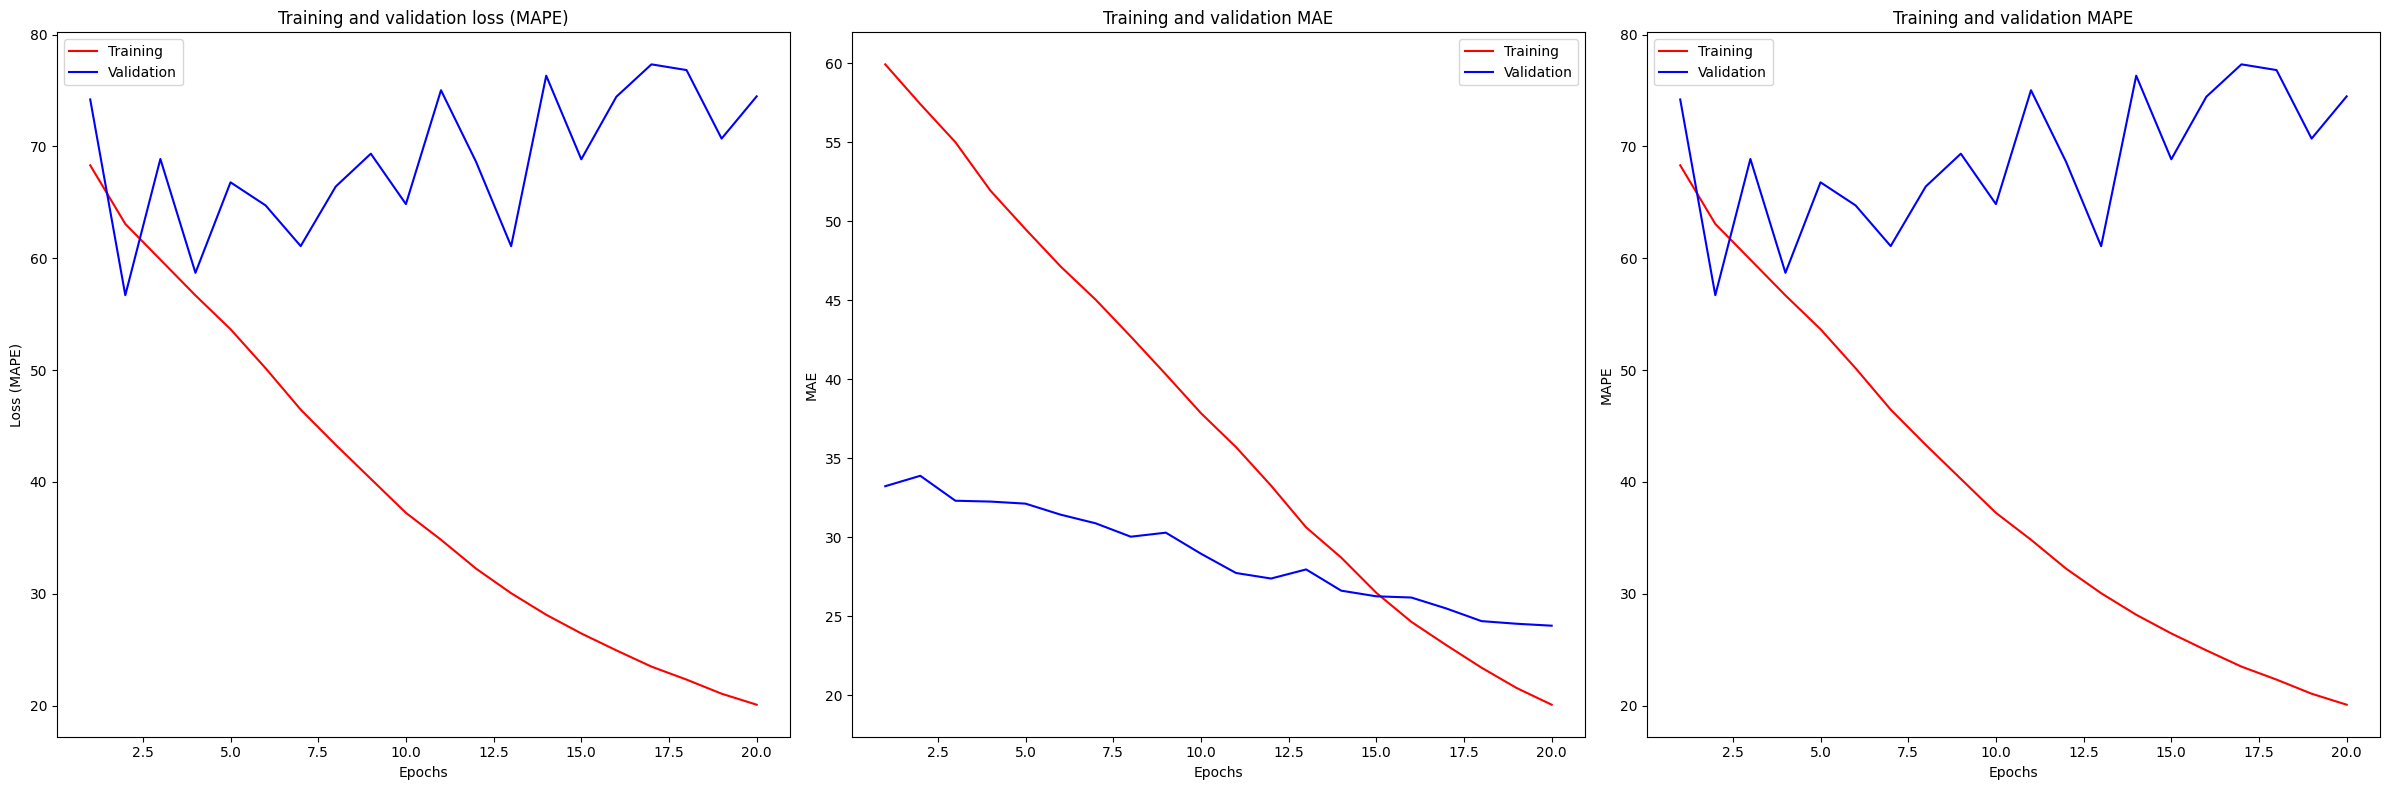

In [39]:
model = models.Sequential()
model.add(layers.Dense(1024, activation = 'relu', input_shape = (partial_train_data.shape[1],)))
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop', loss = 'mape', metrics = ['mae', 'mape'])

history = model \
  .fit(
      partial_train_data, partial_train_targets_corrected,
      validation_data=(validation_train_data, validation_train_targets),
      epochs = 20, batch_size = 20
  ) \
  .history

plot_training_history(history, 'MAPE')

We got slightly better results, but the difference is barely noticeable. Let's continue tuning.

4. Check if the prediction is limited to only positive numbers.

In [42]:
validation_train_predictions = model.predict(validation_train_data).flatten()
validation_train_predictions.min()

15/15 [==============================] - 0s 2ms/step


1.223419

5. Try to remove layers and decrease hidden units.

Epoch 1/20
723/723 [==============================] - 3s 3ms/step - loss: 67.9586 - mae: 60.1042 - mape: 67.9586 - val_loss: 68.5289 - val_mae: 33.3853 - val_mape: 68.5289
Epoch 2/20
723/723 [==============================] - 2s 3ms/step - loss: 63.3815 - mae: 58.1154 - mape: 63.3815 - val_loss: 57.2032 - val_mae: 33.5394 - val_mape: 57.2032
Epoch 3/20
723/723 [==============================] - 2s 3ms/step - loss: 60.6976 - mae: 56.3290 - mape: 60.6976 - val_loss: 65.4277 - val_mae: 32.9999 - val_mape: 65.4277
Epoch 4/20
723/723 [==============================] - 2s 3ms/step - loss: 58.5905 - mae: 54.6762 - mape: 58.5905 - val_loss: 56.9815 - val_mae: 33.3693 - val_mape: 56.9815
Epoch 5/20
723/723 [==============================] - 2s 3ms/step - loss: 56.7021 - mae: 53.4383 - mape: 56.7021 - val_loss: 58.1682 - val_mae: 32.9282 - val_mape: 58.1682
Epoch 6/20
723/723 [==============================] - 2s 3ms/step - loss: 54.8504 - mae: 52.2106 - mape: 54.8504 - val_loss: 60.2140 - val_m

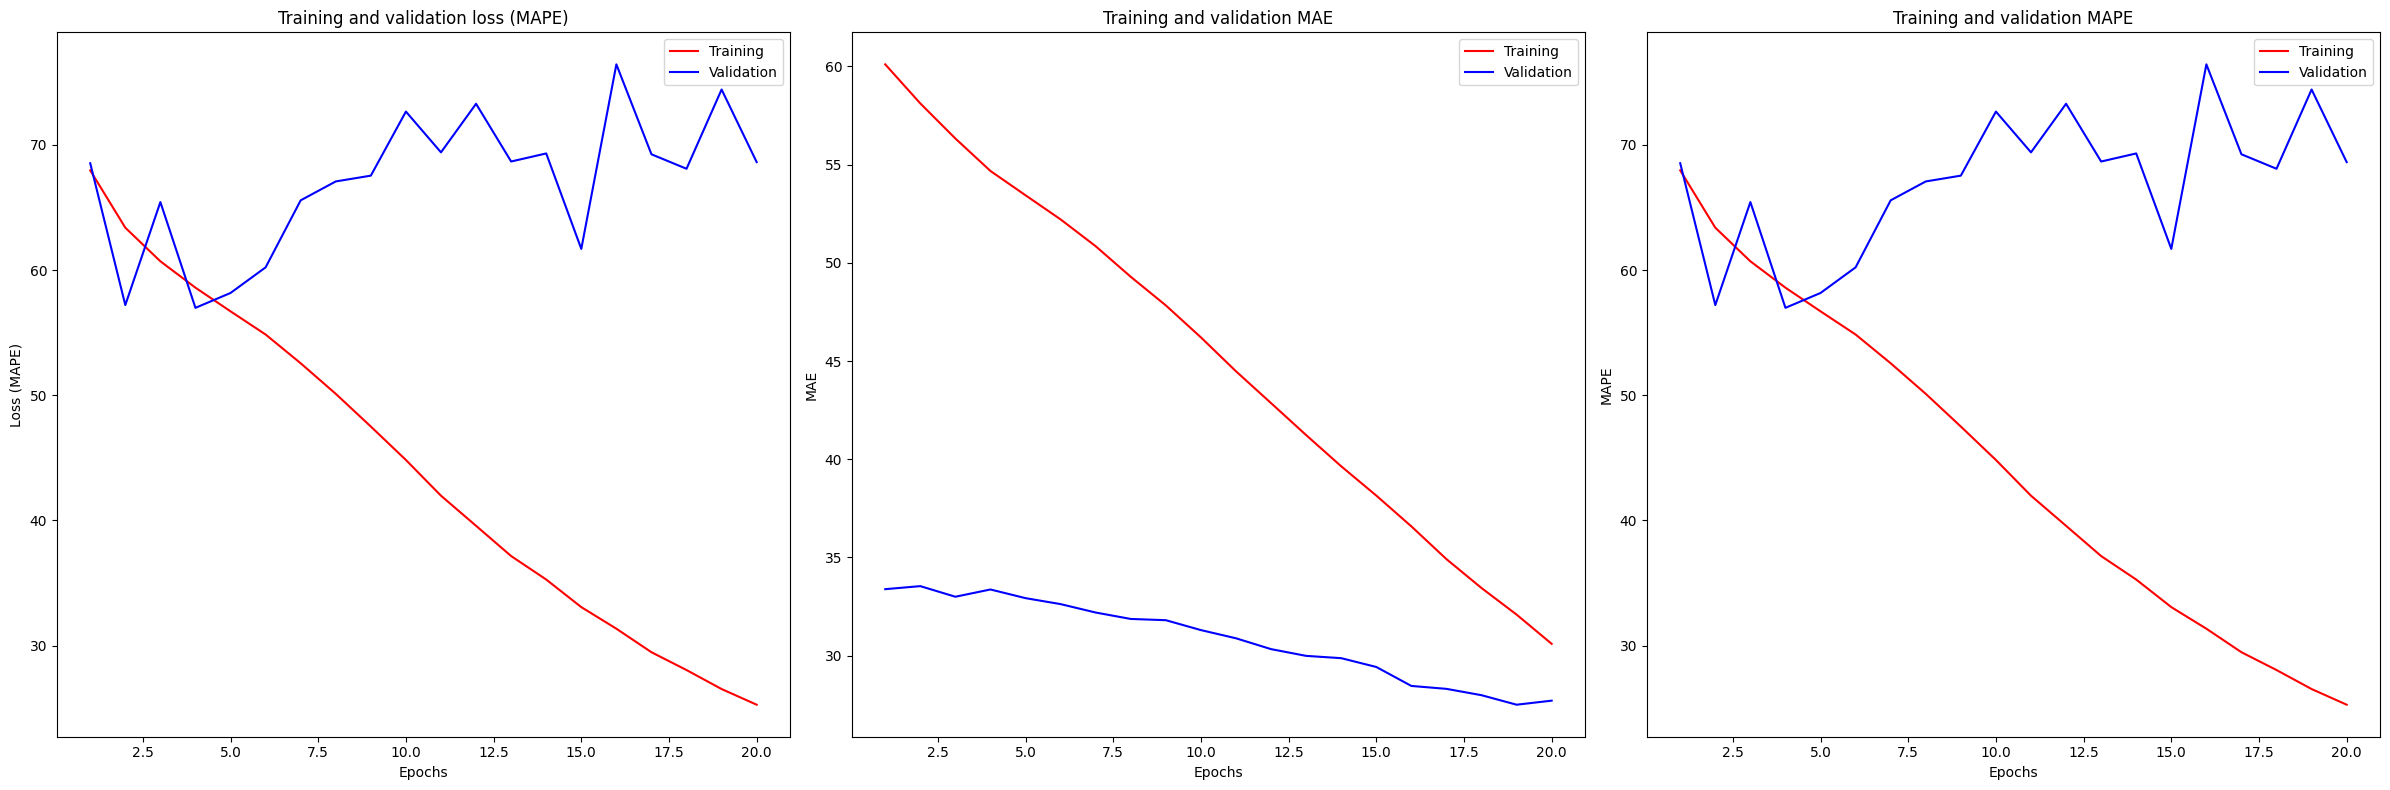

In [43]:
model = models.Sequential()
model.add(layers.Dense(512, activation = 'relu', input_shape = (partial_train_data.shape[1],)))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop', loss = 'mape', metrics = ['mae', 'mape'])

history = model \
  .fit(
      partial_train_data, partial_train_targets_corrected,
      validation_data=(validation_train_data, validation_train_targets),
      epochs = 20, batch_size = 20
  ) \
  .history

plot_training_history(history, 'MAPE')

6. Try to add layers and increase hidden units. As the neural network already overfits, it doesn't make much sense, but we will try.

Epoch 1/20
723/723 [==============================] - 5s 5ms/step - loss: 69.1165 - mae: 60.0739 - mape: 69.1165 - val_loss: 57.4748 - val_mae: 33.9317 - val_mape: 57.4748
Epoch 2/20
723/723 [==============================] - 4s 5ms/step - loss: 63.6258 - mae: 58.3947 - mape: 63.6258 - val_loss: 62.4837 - val_mae: 33.4952 - val_mape: 62.4837
Epoch 3/20
723/723 [==============================] - 4s 5ms/step - loss: 60.7301 - mae: 56.6484 - mape: 60.7301 - val_loss: 66.8876 - val_mae: 33.1283 - val_mape: 66.8876
Epoch 4/20
723/723 [==============================] - 4s 5ms/step - loss: 57.7724 - mae: 54.5256 - mape: 57.7724 - val_loss: 65.8290 - val_mae: 32.8159 - val_mape: 65.8290
Epoch 5/20
723/723 [==============================] - 4s 5ms/step - loss: 55.2543 - mae: 52.3172 - mape: 55.2543 - val_loss: 65.9565 - val_mae: 32.6282 - val_mape: 65.9565
Epoch 6/20
723/723 [==============================] - 3s 5ms/step - loss: 52.3818 - mae: 50.1100 - mape: 52.3818 - val_loss: 63.0457 - val_m

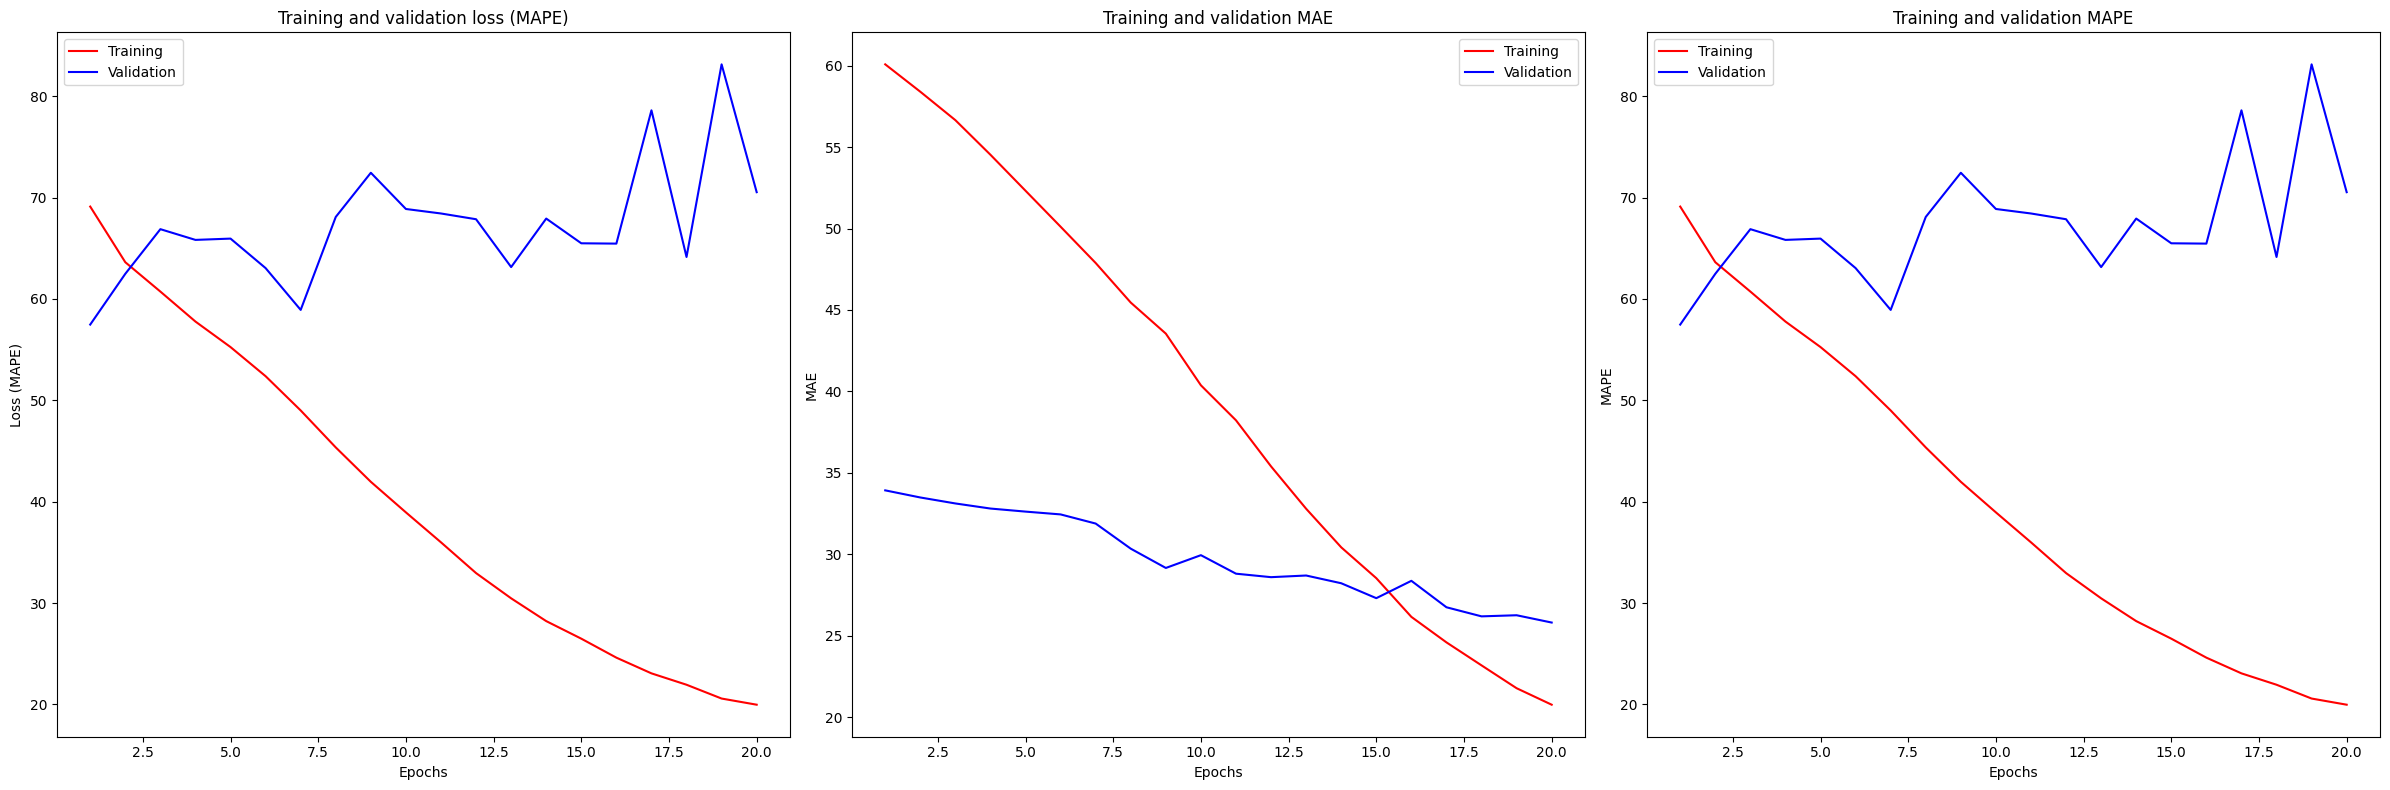

In [44]:
model = models.Sequential()
model.add(layers.Dense(4096, activation = 'relu', input_shape = (partial_train_data.shape[1],)))
model.add(layers.Dense(1024, activation = 'relu'))
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop', loss = 'mape', metrics = ['mae', 'mape'])

history = model \
  .fit(
      partial_train_data, partial_train_targets_corrected,
      validation_data=(validation_train_data, validation_train_targets),
      epochs = 20, batch_size = 20
  ) \
  .history

plot_training_history(history, 'MAPE')

As we can see, removing or adding layers and hidden units does not impact MAPE much, but MAE worsens in both cases. So, let's stick to the initial architecture.
At the same time, it looks like we are starting to overfit the neural network on the validation set. Thus, we have to be more careful and finish the tuning soon.

7. Try optimizer with momentum.

Epoch 1/20
723/723 [==============================] - 4s 4ms/step - loss: 68.2264 - mae: 59.7067 - mape: 68.2264 - val_loss: 63.9516 - val_mae: 33.2597 - val_mape: 63.9516
Epoch 2/20
723/723 [==============================] - 3s 4ms/step - loss: 57.7871 - mae: 55.7354 - mape: 57.7871 - val_loss: 61.1280 - val_mae: 32.5854 - val_mape: 61.1280
Epoch 3/20
723/723 [==============================] - 3s 4ms/step - loss: 49.3993 - mae: 51.4227 - mape: 49.3993 - val_loss: 72.4432 - val_mae: 31.1501 - val_mape: 72.4432
Epoch 4/20
723/723 [==============================] - 3s 4ms/step - loss: 43.1201 - mae: 47.4708 - mape: 43.1201 - val_loss: 79.5161 - val_mae: 29.6536 - val_mape: 79.5161
Epoch 5/20
723/723 [==============================] - 3s 4ms/step - loss: 38.7658 - mae: 43.4892 - mape: 38.7658 - val_loss: 83.9362 - val_mae: 29.0687 - val_mape: 83.9362
Epoch 6/20
723/723 [==============================] - 3s 4ms/step - loss: 34.9014 - mae: 39.9109 - mape: 34.9014 - val_loss: 94.4493 - val_m

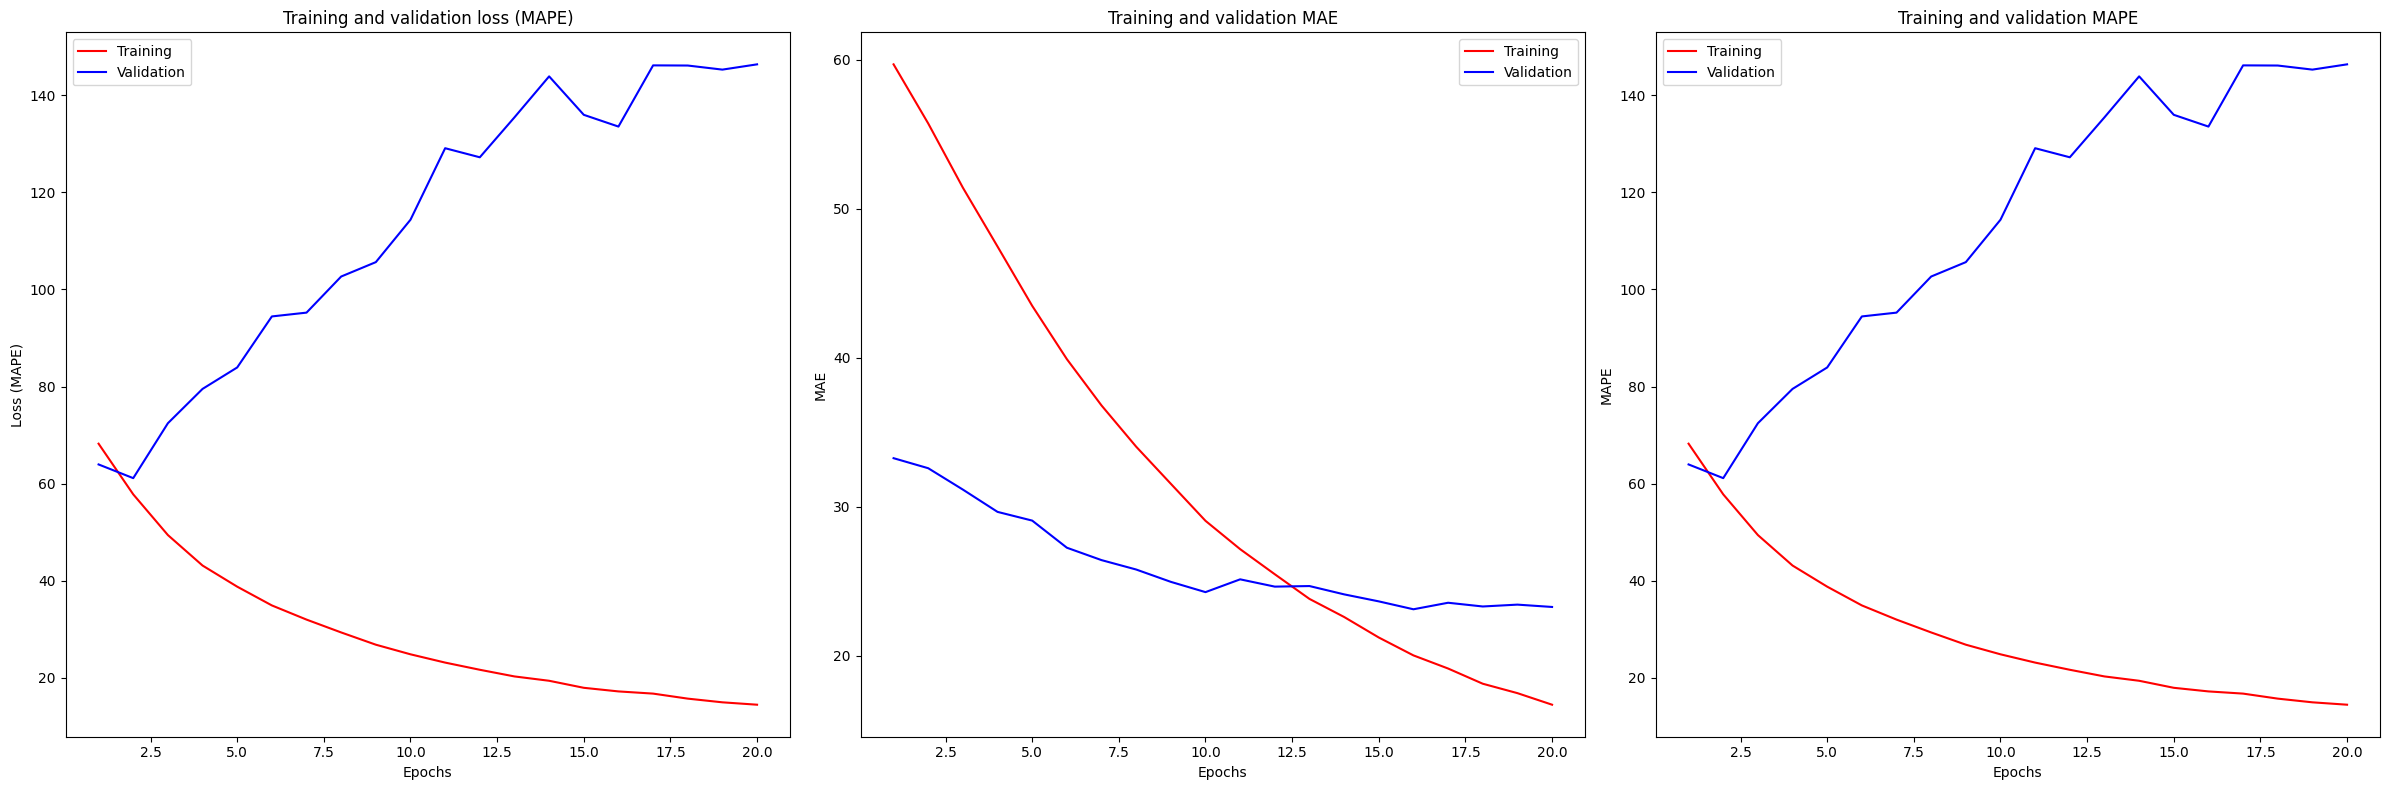

In [52]:
model = models.Sequential()
model.add(layers.Dense(1024, activation = 'relu', input_shape = (partial_train_data.shape[1],)))
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(1))
model.compile(optimizer='adam', loss = 'mape', metrics = ['mae', 'mape'])

history = model \
  .fit(
      partial_train_data, partial_train_targets_corrected,
      validation_data=(validation_train_data, validation_train_targets),
      epochs = 20, batch_size = 20
  ) \
  .history

plot_training_history(history, 'MAPE')

It overfits too fast and improves MAE a bit, but MAPE is increasing too much. Again, let's stick to the initially chosen RMSprop.
It is not shown here to reduce the notebook's size, but I experimented with different optimizers, and RMSprop showed the best balance between MAE and MAPE.

8. Try different activation functions.

Epoch 1/20
723/723 [==============================] - 4s 4ms/step - loss: 69.0223 - mae: 60.2603 - mape: 69.0223 - val_loss: 57.6543 - val_mae: 33.9001 - val_mape: 57.6543
Epoch 2/20
723/723 [==============================] - 3s 3ms/step - loss: 64.4738 - mae: 58.3553 - mape: 64.4738 - val_loss: 65.1134 - val_mae: 33.0724 - val_mape: 65.1134
Epoch 3/20
723/723 [==============================] - 3s 4ms/step - loss: 61.3639 - mae: 56.0882 - mape: 61.3639 - val_loss: 72.1900 - val_mae: 32.8110 - val_mape: 72.1900
Epoch 4/20
723/723 [==============================] - 2s 3ms/step - loss: 59.0387 - mae: 53.6023 - mape: 59.0387 - val_loss: 70.8016 - val_mae: 32.5614 - val_mape: 70.8016
Epoch 5/20
723/723 [==============================] - 3s 3ms/step - loss: 56.3022 - mae: 50.8093 - mape: 56.3022 - val_loss: 58.5128 - val_mae: 32.3281 - val_mape: 58.5128
Epoch 6/20
723/723 [==============================] - 3s 3ms/step - loss: 54.1005 - mae: 48.7907 - mape: 54.1005 - val_loss: 62.6596 - val_m

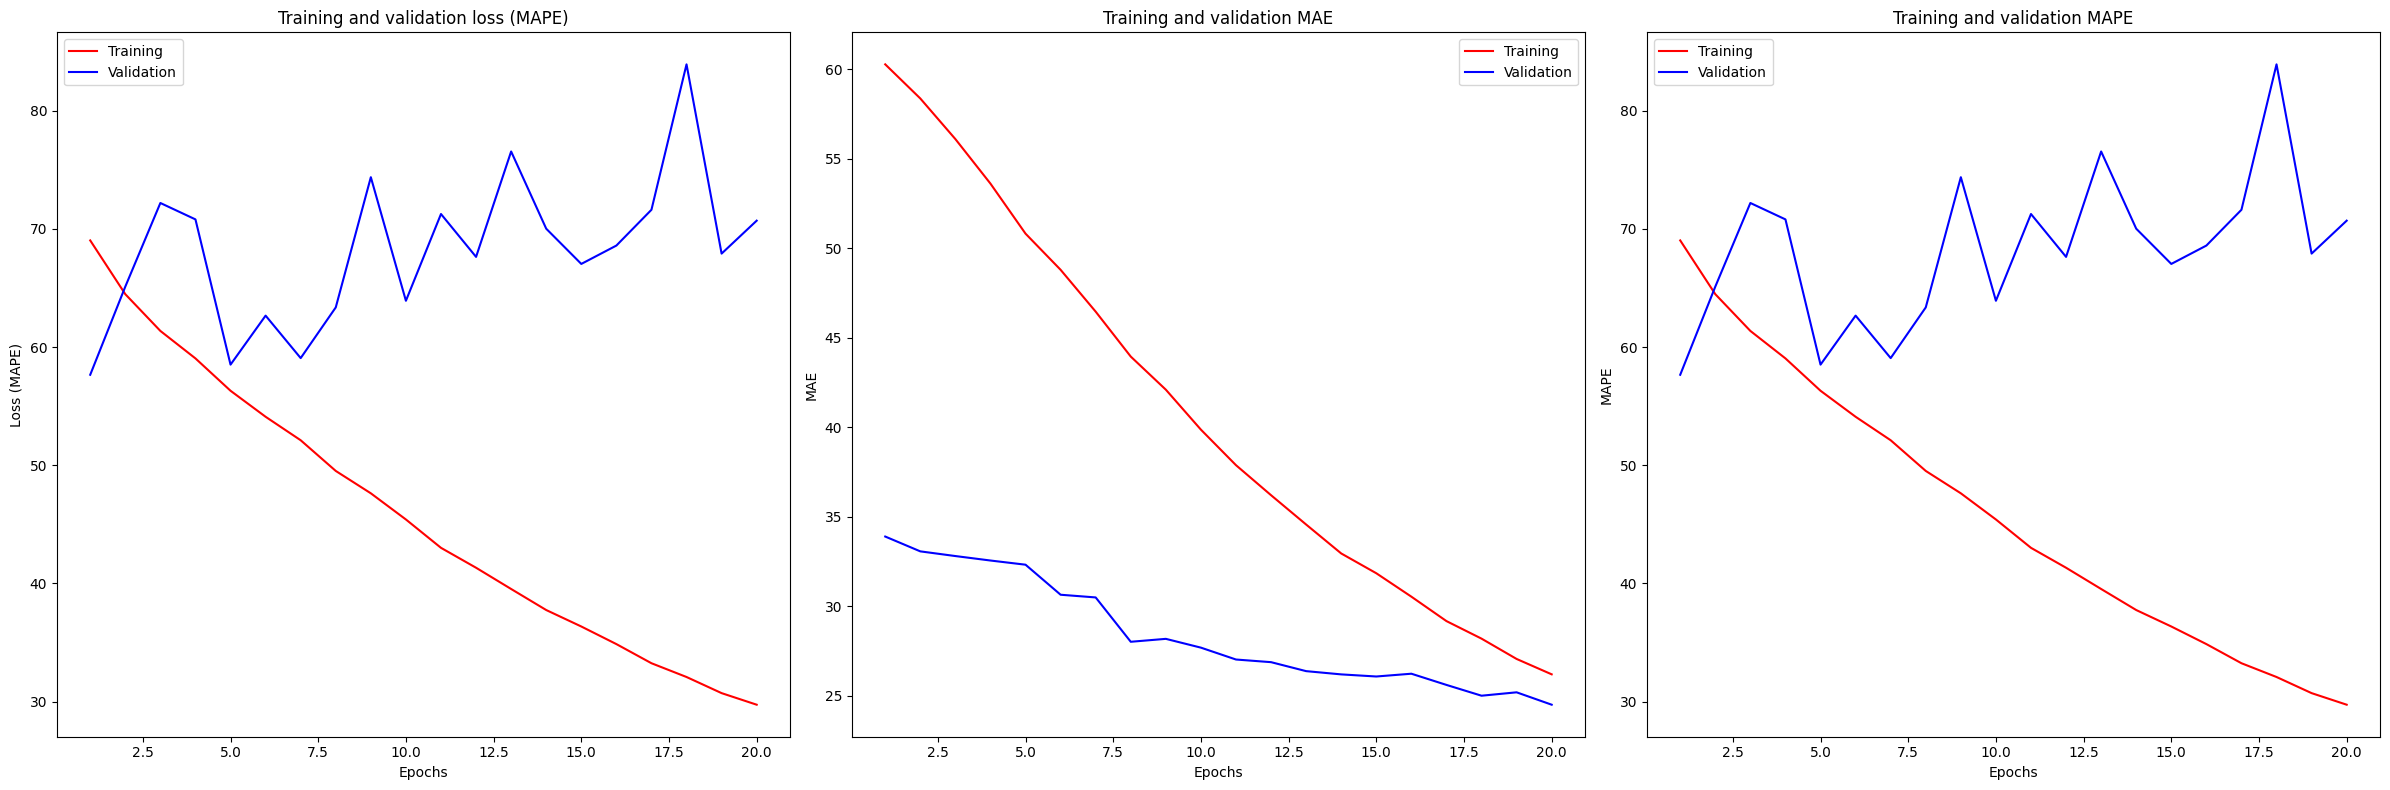

In [58]:
model = models.Sequential()
model.add(layers.Dense(1024, activation = 'elu', input_shape = (partial_train_data.shape[1],)))
model.add(layers.Dense(512, activation = 'elu'))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop', loss = 'mape', metrics = ['mae', 'mape'])

history = model \
  .fit(
      partial_train_data, partial_train_targets_corrected,
      validation_data=(validation_train_data, validation_train_targets),
      epochs = 20, batch_size = 20
  ) \
  .history

plot_training_history(history, 'MAPE')

Such experiments also do not show better results.
It is not shown here for the sake of reducing the size of the notebook. Still, I experimented with different combinations of activation functions, and default relu does not have much difference with different options here.

9. Try Dropout layers.

Epoch 1/20
723/723 [==============================] - 4s 4ms/step - loss: 68.6554 - mae: 59.8344 - mape: 68.6554 - val_loss: 57.3794 - val_mae: 33.8065 - val_mape: 57.3794
Epoch 2/20
723/723 [==============================] - 3s 4ms/step - loss: 63.5438 - mae: 57.1018 - mape: 63.5438 - val_loss: 74.3076 - val_mae: 32.6537 - val_mape: 74.3076
Epoch 3/20
723/723 [==============================] - 3s 4ms/step - loss: 60.1764 - mae: 54.3250 - mape: 60.1764 - val_loss: 56.0598 - val_mae: 33.4550 - val_mape: 56.0598
Epoch 4/20
723/723 [==============================] - 3s 4ms/step - loss: 57.3153 - mae: 51.6843 - mape: 57.3153 - val_loss: 60.8760 - val_mae: 32.4737 - val_mape: 60.8760
Epoch 5/20
723/723 [==============================] - 3s 4ms/step - loss: 54.7049 - mae: 49.3359 - mape: 54.7049 - val_loss: 69.9436 - val_mae: 31.8233 - val_mape: 69.9436
Epoch 6/20
723/723 [==============================] - 3s 4ms/step - loss: 51.7086 - mae: 47.0611 - mape: 51.7086 - val_loss: 62.5026 - val_m

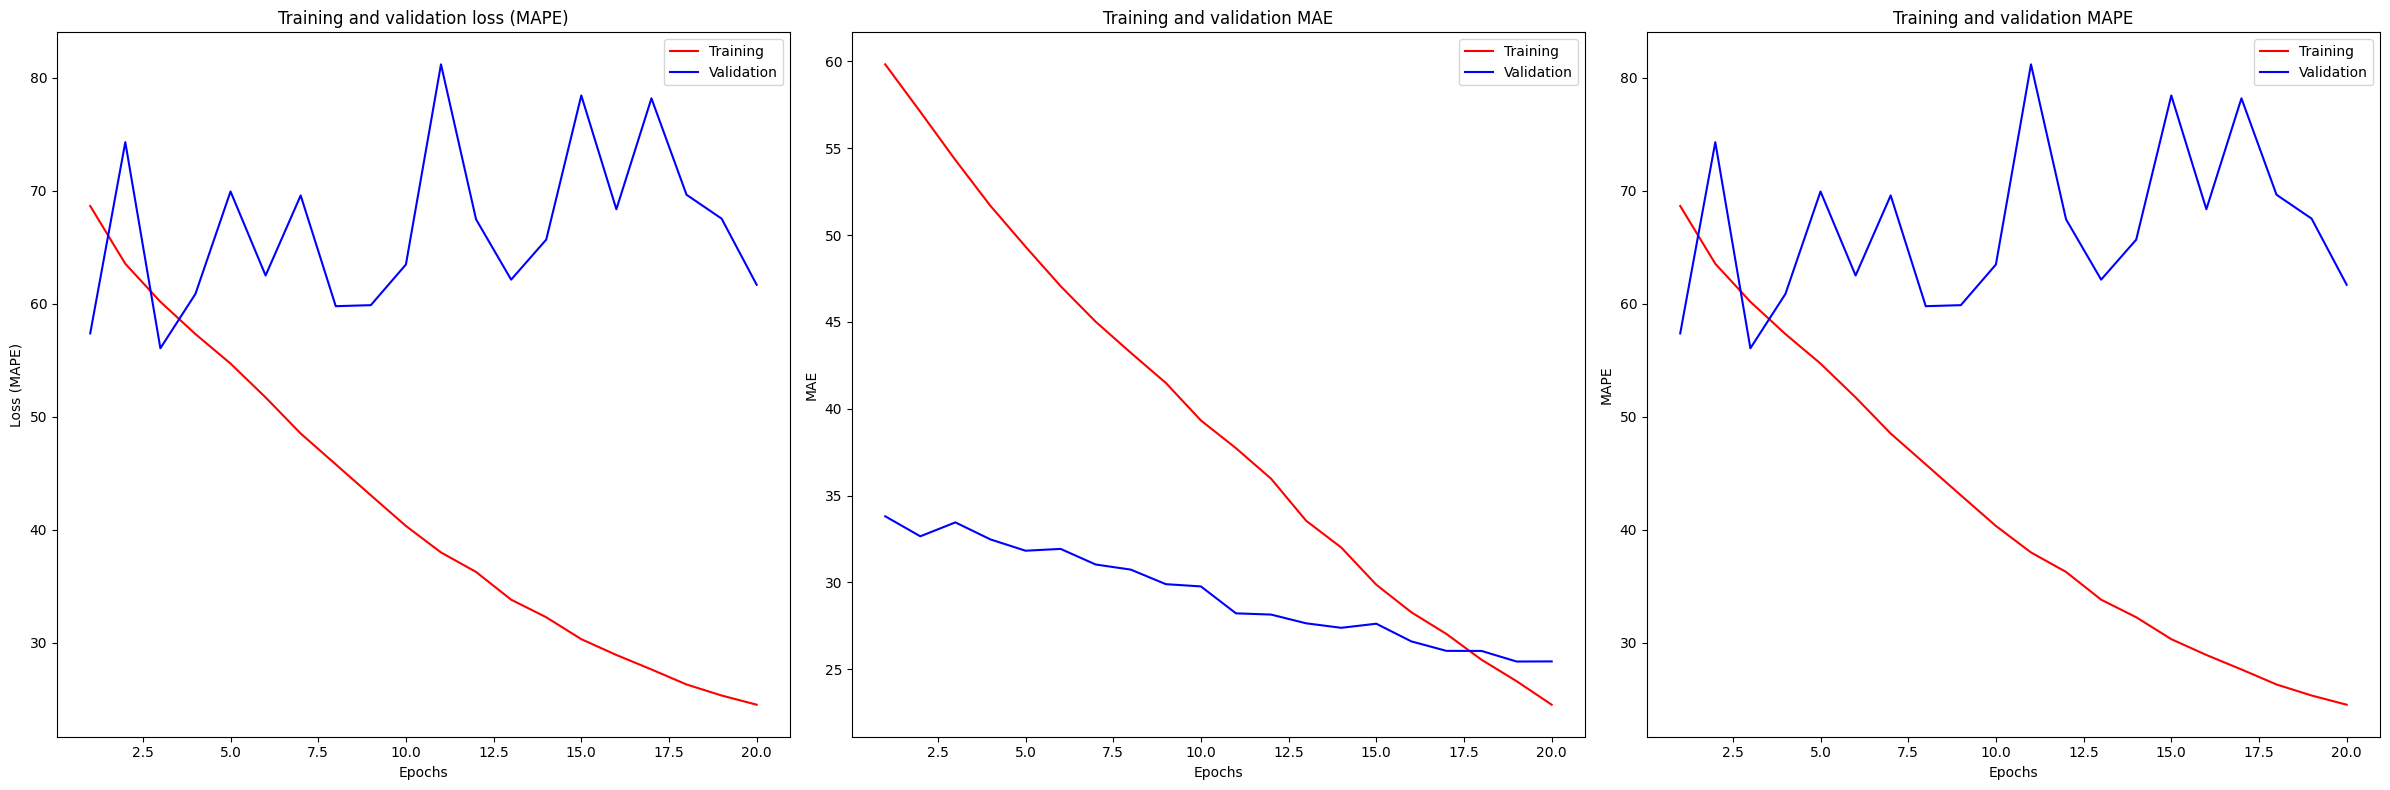

In [26]:
model = models.Sequential()
model.add(layers.Dense(1024, activation = 'relu', input_shape = (partial_train_data.shape[1],)))
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dropout(0.15))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop', loss = 'mape', metrics = ['mae', 'mape'])

history = model \
  .fit(
      partial_train_data, partial_train_targets_corrected,
      validation_data=(validation_train_data, validation_train_targets),
      epochs = 20, batch_size = 20
  ) \
  .history

plot_training_history(history, 'MAPE')

It is not shown here to reduce the notebook's size, but I experimented with different combinations of Dropout layers. Some options give a smoother Validation MAPE curve, but there is little difference regarding metrics values.

10. Try L1 and/or L2 regularization.

Epoch 1/100
723/723 [==============================] - 4s 4ms/step - loss: 135.1281 - mae: 60.3936 - mape: 69.2795 - val_loss: 60.7230 - val_mae: 34.2468 - val_mape: 57.6526
Epoch 2/100
723/723 [==============================] - 3s 4ms/step - loss: 68.4230 - mae: 59.3445 - mape: 65.1596 - val_loss: 59.4918 - val_mae: 33.9438 - val_mape: 56.4630
Epoch 3/100
723/723 [==============================] - 3s 4ms/step - loss: 66.0645 - mae: 58.2025 - mape: 62.8221 - val_loss: 64.9375 - val_mae: 33.2919 - val_mape: 61.5854
Epoch 4/100
723/723 [==============================] - 3s 4ms/step - loss: 64.3247 - mae: 57.1558 - mape: 61.0962 - val_loss: 61.2156 - val_mae: 33.4752 - val_mape: 58.1971
Epoch 5/100
723/723 [==============================] - 3s 3ms/step - loss: 63.1723 - mae: 56.4329 - mape: 59.9708 - val_loss: 65.0806 - val_mae: 33.0443 - val_mape: 61.6800
Epoch 6/100
723/723 [==============================] - 3s 4ms/step - loss: 62.1738 - mae: 55.5998 - mape: 58.9153 - val_loss: 71.1671 

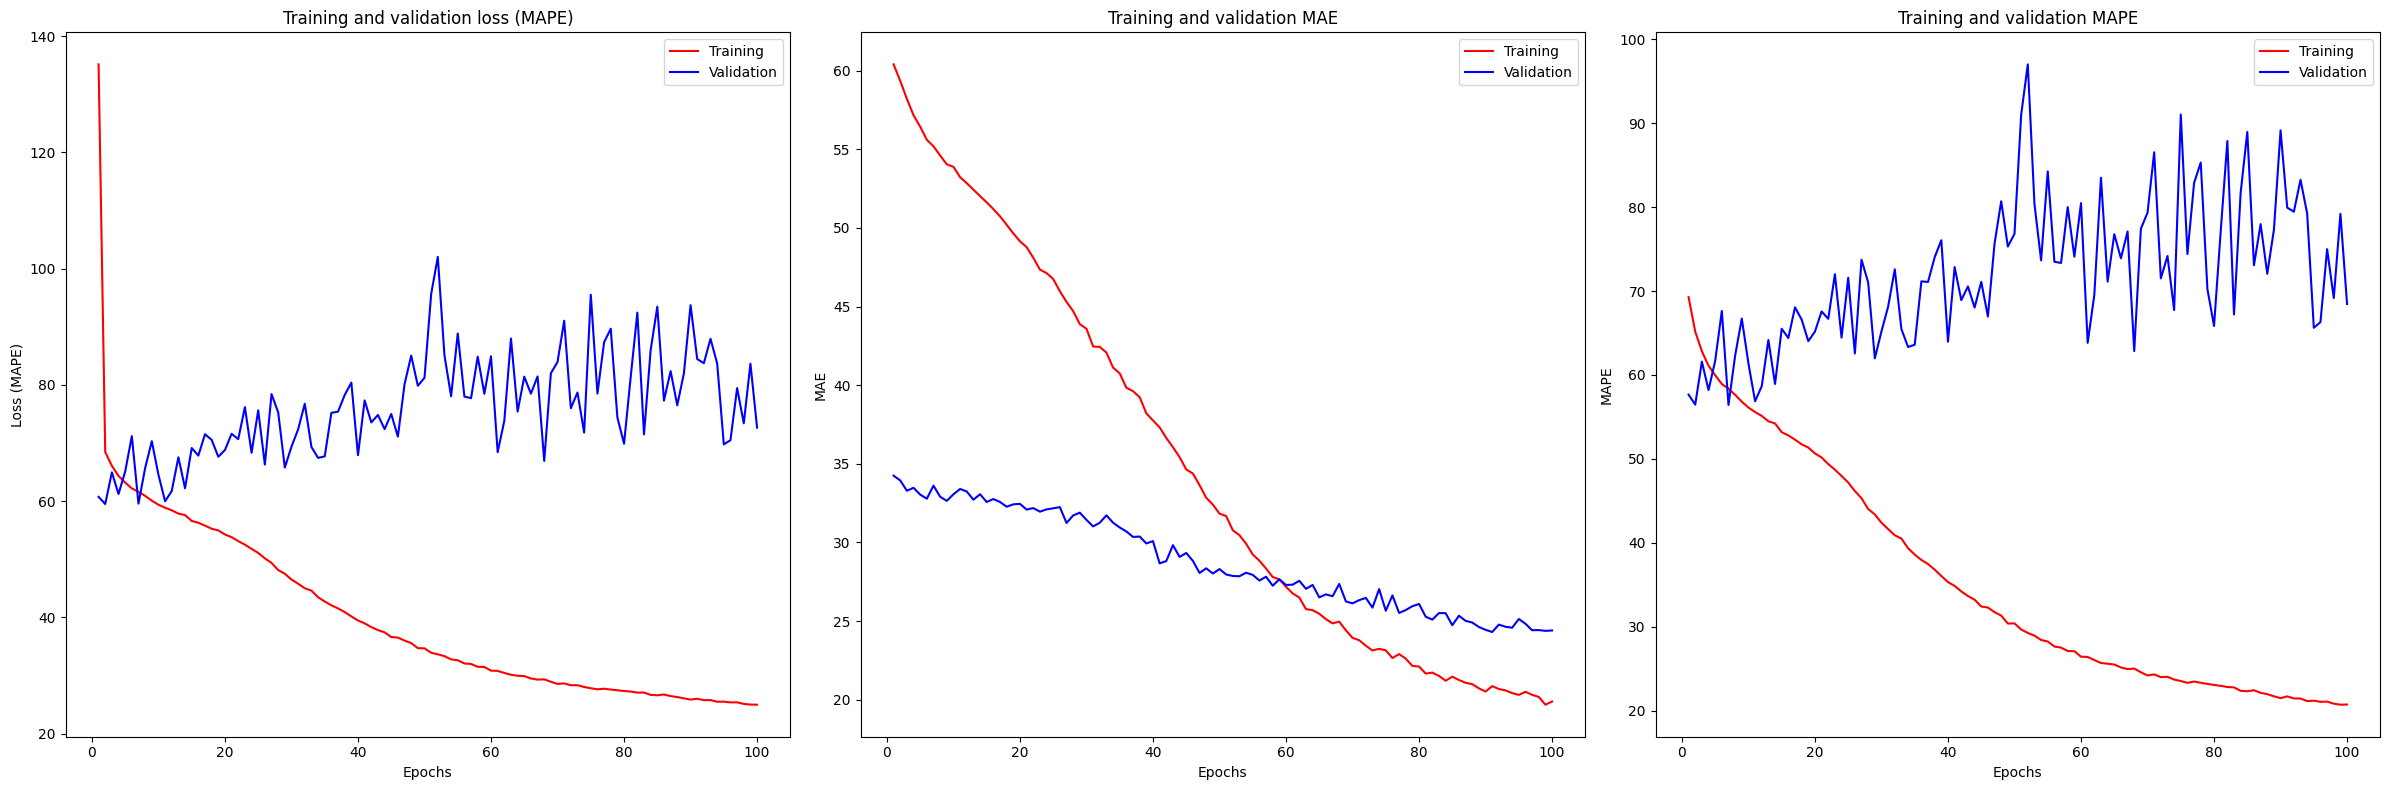

In [33]:
model = models.Sequential()
model.add(layers.Dense(1024, activation = 'relu', input_shape = (partial_train_data.shape[1],)))
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, activation = 'relu', kernel_regularizer = l1_l2(0.15, 15)))
model.add(layers.Dropout(0.15))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop', loss = 'mape', metrics = ['mae', 'mape'])

history = model \
  .fit(
      partial_train_data, partial_train_targets_corrected,
      validation_data=(validation_train_data, validation_train_targets),
      epochs = 100, batch_size = 20
  ) \
  .history

plot_training_history(history, 'MAPE')

I tried different combinations of Dropout layers and L1/L2 regularizations to slow down overfitting, but it doesn't change much, even with increased epochs.

Let's train and save the final version of the model on the whole dataset. It is similar to the initial version, as the tunning approaches I tried did not help.

In [38]:
train_data = np.concatenate((partial_train_data, validation_train_data), axis=0)
train_targets = np.concatenate((partial_train_targets_corrected, validation_train_targets), axis=0)

final_model = models.Sequential()
final_model.add(layers.Dense(1024, activation = 'relu', input_shape = (partial_train_data.shape[1],)))
final_model.add(layers.Dense(512, activation = 'relu'))
final_model.add(layers.Dense(64, activation = 'relu'))
final_model.add(layers.Dense(1))
final_model.compile(optimizer='rmsprop', loss = 'mape', metrics = ['mae', 'mape'])

final_history = final_model \
  .fit(train_data, train_targets, epochs = 15, batch_size = 20) \
  .history

final_model.save('/content/drive/MyDrive/data/final_model.keras')

Epoch 1/15
745/745 [==============================] - 3s 3ms/step - loss: 68.0187 - mae: 59.1955 - mape: 68.0187
Epoch 2/15
745/745 [==============================] - 3s 3ms/step - loss: 63.1248 - mae: 56.7581 - mape: 63.1248
Epoch 3/15
745/745 [==============================] - 2s 3ms/step - loss: 59.9328 - mae: 54.2376 - mape: 59.9328
Epoch 4/15
745/745 [==============================] - 2s 3ms/step - loss: 56.8502 - mae: 51.6891 - mape: 56.8502
Epoch 5/15
745/745 [==============================] - 2s 3ms/step - loss: 53.8310 - mae: 49.3963 - mape: 53.8310
Epoch 6/15
745/745 [==============================] - 2s 3ms/step - loss: 50.5372 - mae: 47.1547 - mape: 50.5372
Epoch 7/15
745/745 [==============================] - 3s 3ms/step - loss: 47.1640 - mae: 45.2310 - mape: 47.1640
Epoch 8/15
745/745 [==============================] - 2s 3ms/step - loss: 43.6997 - mae: 43.0060 - mape: 43.6997
Epoch 9/15
745/745 [==============================] - 2s 3ms/step - loss: 40.5933 - mae: 40.6752

Load the final model and the test dataset.

In [39]:
final_model = models.load_model('/content/drive/MyDrive/data/final_model.keras')

with open('/content/drive/MyDrive/data/test_data.npy', 'rb') as f:
    test_data = np.load(f)
with open('/content/drive/MyDrive/data/test_targets.npy', 'rb') as f:
    test_targets = np.load(f)

Evaluate on the test dataset.

In [41]:
test_loss, test_mae, test_mape = final_model.evaluate(test_data, test_targets)

print(f'Test Loss: {test_loss}')
print(f'Test MAE: {test_mae}')
print(f'Test MAPE: {test_mape}')

13/13 [==============================] - 0s 3ms/step - loss: 70.1722 - mae: 31.2885 - mape: 70.1722
Test Loss: 70.17218017578125
Test MAE: 31.288455963134766
Test MAPE: 70.17218017578125


Build a residual plot to check the distribution of residuals.

In [ ]:
test_predictions = model.predict(test_data).flatten()

residuals = test_predictions - test_targets

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))

sns.residplot(x = test_predictions, y = residuals, lowess = True, ax = ax1)
ax1.set_title('Residuals')
ax1.set_xlabel('Box office')
ax1.set_ylabel('Residuals')

sns.kdeplot(x = residuals, fill = True, linewidth = 0, ax = ax2)

normal_mean, normal_std = stats.norm.fit(residuals)
x = np.linspace(residuals.min(), residuals.max(), 100)
ax2.plot(x, stats.norm.pdf(x, normal_mean, normal_std), color = 'green')

ax2.set_title(f'Residuals distribution')
ax2.set_xlabel('Residuals')
ax2.set_ylabel(f'Density')

plt.tight_layout()
plt.show()

Results on the test dataset are definitely better than the baseline. We may observe some predictive power of the model, but clearly, there are not enough features to provide higher performance. Also, there were not many options to improve the results. Perhaps this task with the used set of features can be resolved with more simple models than neural networks, for example, Linear Regression.

The residuals plot does not show the expected random distribution of residuals, but at least we can see that the smaller the predicted box office, the smaller the error.
Residual distribution is close to a normal distribution, so, at least, the approach with a neural network here is not complete nonsense.